# Project Overview

## OSEMN Pipeline

* O - Obtaining our data - in OS_dataset_cleanup
* S - Scrubbing/Cleaning our data - in OS_dataset_cleanup
* E - Exploring/Visualizing our data
* M - Modeling our data
* N - Interpreting the data

## Package Imports

In [1]:
# basic tools
import pandas as pd
import numpy as np
from numpy import argmax
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_validate, HalvingGridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import LearningCurve

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')


## Notebook Functions

### Pipeline Cleaning Functions

In [2]:
def pipeline_fit_preprocessor(x):
    
    ''' Takes in a dataframe and adds polynomial features and scaling
    arguments: dataframe
    returns: transformed dataframe and fit pipe object'''
    
    
    # Create a column transformer to add polynomial features to Segment Number
    print("Setting up transforms - Polynomials, StandardScaler")
    poly_transforms = ColumnTransformer(transformers=[
        ("polys", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ], remainder="passthrough") 
    
    

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms1', poly_transforms),
                ('scl', StandardScaler()),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    ''' Takes in a dataframe and fit pipe object,
    and adds polynomial features and scaling
    arguments: dataframe, pipe object
    returns: transformed dataframe'''
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df


### Tuning Functions

In [3]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='f1', cv=5, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best f1: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

### Scoring Functions

In [4]:
def train_scoring(model, x, y):
    
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5,
        scoring=('f1', 'accuracy', 'roc_auc', 'recall', 'precision'),
        return_train_score=True)
    f1 = round(scores['test_f1'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc'].mean()*100, 2)
    recall = round(scores['test_recall'].mean()*100, 2)
    prec = round(scores['test_precision'].mean()*100, 2)
    
    print("CV 5 Accuracy Train Score: {}".format(accs))
    print("CV 5 F1 Train Score: {}".format(f1))
    print("CV 5 Auc Train Score: {}".format(auc))
    print("CV 5 Precision Train Score: {}".format(prec))
    print("CV 5 Recall Train Score: {}".format(recall))

In [5]:
def validation_scoring(model, x, y, title, score_list, thresh=.5):
    
    probabilities = model.predict_proba(x)
    predictions = (probabilities[:,1] >= thresh).astype(bool)
    
    accs = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions)
    auc = roc_auc_score(y, predictions)
    recall = recall_score(y, predictions)
    prec = precision_score(y, predictions)
    
    print('\nValidation Accuracy (',thresh,'Thresh)): ', accs)
    print('Validation f1 Score (',thresh,'Thresh): ', f1)
    print('Validation AUC Score (',thresh,'Thresh): ', auc)
    print('Validation Precision Score (',thresh,'Thresh): ', prec)      
    print('Validation Recall Score (',thresh,'Thresh): ', recall, '\n')
    
    # print classification report
    print(classification_report(y, predictions))
    
    # append our scores to our lists
    score_list['Model'].append(title)
    score_list['f1'].append(f1)
    score_list['accuracy'].append(accs)
    score_list['auc'].append(auc)
    score_list['precision'].append(prec)
    score_list['recall'].append(recall)
    
    
    return probabilities, predictions, score_list

In [6]:
def simple_score(y_pred, y_actual, label):
    # Print validation accuracy

    accs = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    auc = roc_auc_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    prec = precision_score(y_actual, y_pred)
    
    print('\n',label,'Accuracy (Ideal Thresh)): ', accs)
    print(label,'f1 Score (Ideal Thresh): ', f1)
    print(label,'AUC Score (Ideal Thresh): ', auc)
    print(label,'Precision Score (Ideal Thresh): ', prec)      
    print(label,'Recall Score (Ideal Thresh): ', recall, '\n')
    
    # print classification report
    print(classification_report(y_actual, preds)) 

### Visualization Functions

In [7]:
def plot_roc(testy, yhat):
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate roc curves
    precision, recall, thresholds = precision_recall_curve(testy, yhat)
    
    # get f score
    fscore = (2 * precision * recall) / (precision + recall)
    
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    # plot the roc curve for the model
    no_skill = len(testy[testy==1]) / len(testy)
    plt.figure(figsize=(15,10))
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Model')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    
    # show the plot
    plt.show()

In [8]:
def plot_auc(model, test, y_test):
    try:
    # Get false positive, true positive, thresholds
        y_score = model.decision_function(test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score)

        # Visualize AUC
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
        plt.figure(figsize=(15,10))
        plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    except:
        pass

### Modeling Functions

In [9]:
def spot_check_classifier(model, train, y_train, title, test, y_test, score_list):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 3 and appends model scores to the list
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    train_scoring(model, train, y_train)
    
    probs, preds, scores = validation_scoring(model, test, y_test, title, score_list)
    
    score_list['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}') 
    
    return scores

In [10]:
def make_classifier(model, train, test, y_train, y_test, title, important_features, score_list):
    
    '''Takes in a model as well as train and test sets. Runs model using cv 5 and appends model scores to the list.
    This model prints a confusion matrix and visual ROCUC. 
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    train_scoring(model, train, y_train)
        
    probs, preds, scores = validation_scoring(model, test, y_test, title, score_list)
      
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
    
    plot_roc(y_test, probs)
    
    plot_auc(model, test, y_test)
    
    try:
        feat_importances = pd.Series(model.feature_importances_, index=important_features)
        feat_importances.nlargest(10).plot(kind='barh')
            # save figure to png
        plt.savefig('images/',title,'.png')
        ;
    except:
        pass
    
    score_list['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return model, scores


### Stacking Functions

In [11]:
# create a meta dataset with each column comprised of the predictions from level 1, as well as a column with the original data
def create_meta_dataset(data_x, yhat1, yhat2, yhat3, yhat4, yhat5):
      
    # convert to columns
    yhat1 = np.array(yhat1).reshape((len(yhat1), 1))
    yhat2 = np.array(yhat2).reshape((len(yhat2), 1))
    yhat3 = np.array(yhat3).reshape((len(yhat3), 1))
    yhat4 = np.array(yhat4).reshape((len(yhat4), 1))
    yhat5 = np.array(yhat5).reshape((len(yhat5), 1))
    
    # stack as separate columns
    meta_X = np.hstack((data_x, yhat1, yhat2, yhat3, yhat4, yhat5))
    return meta_X


In [12]:
# Predict on new data using the base models and meta model
def stack_prediction(model1, model2, model3, model4, model5, meta_model, X, y_val, thresh=.5):
    
    # make predictions
    yhat1 = model1.predict_proba(X)[:, 0]
    yhat2 = model2.predict_proba(X)[:, 0]
    yhat3 = model3.predict_proba(X)[:, 0]
    yhat4 = model4.predict_proba(X)[:, 0]
    yhat5 = model5.predict_proba(X)[:, 0] 
    
    # create input dataset
    meta_X = create_meta_dataset(X, yhat1, yhat2, yhat3, yhat4, yhat5)

    # predict
    return meta_X



# Exploring/Visualizing Data

In [13]:
# Load ALL Data
final = pd.read_pickle("data/pkl/train.pkl")
final

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,3,1,0,0800-0859,9,1,22,176,American Airlines Inc.,7956,...,NONE,0.00,0.0,0.0,89.0,6.71,0.191048,0.193576,0.161062,0.108412
1,4,1,0,1600-1659,6,1,24,198,United Air Lines Inc.,11588,...,NONE,1.00,0.0,0.0,70.0,19.01,0.183479,0.193576,0.238144,0.245646
2,2,1,0,1700-1759,1,5,58,90,Comair Inc.,28011,...,Douglas Municipal,0.03,0.0,0.0,56.0,4.92,0.213952,0.194913,0.229308,0.279710
3,2,3,0,0700-0759,1,1,19,143,Southwest Airlines Co.,11500,...,NONE,0.00,0.0,0.0,50.0,11.41,0.259242,0.193576,0.232799,0.106187
4,10,1,1,1100-1159,1,2,31,143,Southwest Airlines Co.,14566,...,Nashville International,0.00,0.0,0.0,79.0,3.58,0.180073,0.167245,0.164703,0.146768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577099,6,3,0,0700-0759,2,1,20,180,Delta Air Lines Inc.,6007,...,NONE,0.06,0.0,0.0,89.0,10.74,0.200541,0.193576,0.237426,0.111132
4577100,3,6,1,2000-2059,3,7,42,143,Southwest Airlines Co.,33799,...,Louis Armstrong New Orleans International,0.00,0.0,0.0,75.0,9.62,0.204318,0.172423,0.191000,0.232049
4577101,7,2,0,1500-1559,2,3,31,76,SkyWest Airlines Inc.,10124,...,Friedman Memorial,0.00,0.0,0.0,101.0,7.61,0.188983,0.193576,0.202202,0.253874
4577102,2,3,0,1600-1659,1,5,31,50,Endeavor Air Inc.,12355,...,Bangor International,0.47,0.0,0.0,46.0,10.51,0.202523,0.193576,0.232799,0.271246


In [14]:
# check distribution of target

print('Raw counts: \n')
print(final['DEP_DEL15'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DEP_DEL15'].value_counts(normalize=True))

Raw counts: 

0    3685343
1     891761
Name: DEP_DEL15, dtype: int64
-----------------------------------
Normalized counts: 

0    0.805169
1    0.194831
Name: DEP_DEL15, dtype: float64


In [15]:
# check mean values per feature on target
final.groupby('DEP_DEL15').mean()

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEP_DEL15,,,,,,,,,,,,,,,,,,,,,
0,3.806457,2.948302,27.779626,133.466159,12651.640470,63370.238410,3451.024002,1.574681e+06,7.813257e+06,0.000098,...,-94.567961,0.092285,0.023937,0.082089,71.798866,8.200483,0.192249,0.191720,0.193268,0.187156
1,3.902545,3.481995,28.253034,134.964834,13248.563454,63490.969719,3603.831333,1.645055e+06,7.820209e+06,0.000097,...,-93.110158,0.162725,0.062204,0.126227,71.949169,8.604105,0.205499,0.201248,0.201289,0.226548


Initial assessments:

* Average segment number for delay is higher
* Delays are at slightly busier airports
* Precipitation/Snow are slightly higher avg for delays

## Visualizations of delay by feature

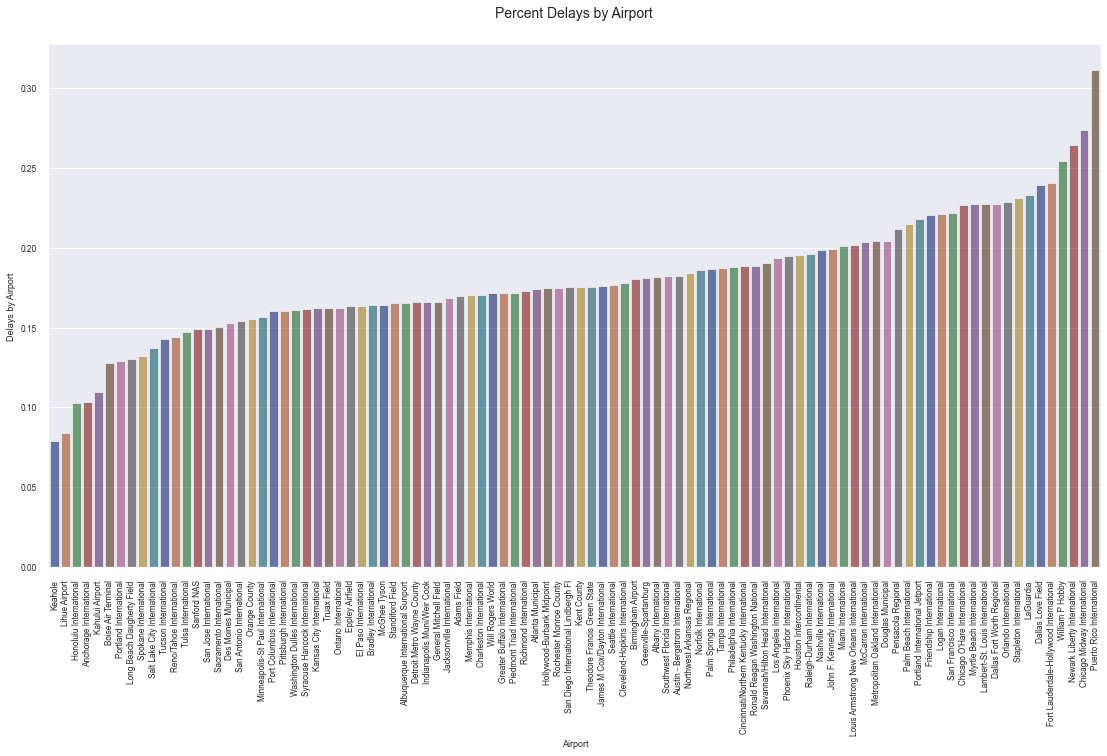

In [15]:
# Visualize delays by airport

sns.set(font_scale = .75) #decreasing our font size a bit

plot_order = final.groupby('DEPARTING_AIRPORT')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

g = sns.catplot(
    data=final, kind="bar",
    x="DEPARTING_AIRPORT", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2, order=plot_order
)
g.despine(left=True)
g.set_xticklabels(rotation=90, horizontalalignment='center')
g.set_axis_labels("Airport", "Delays by Airport")
g.fig.suptitle("Percent Delays by Airport", y = 1.05, size=14);


In [16]:
# df of highest delay by airport

final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=False).head(15)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEPARTING_AIRPORT,,,,,,,,,,,,,,,,,,,,,
Puerto Rico International,0.311475,6.098361,2.262295,7.262295,160.180328,2293.000000,50879.901639,488.622951,364406.0,7.489536e+06,...,-66.002,0.000000,0.000000,0.000000,0.000000,0.000000,0.206290,0.189211,0.159549,0.165825
Chicago Midway International,0.273632,3.656930,3.510256,14.391873,148.229922,6820.542084,109646.561287,5976.237136,819756.0,1.297762e+07,...,-87.752,0.122632,0.091403,0.289242,60.072020,9.396525,0.211309,0.191498,0.194905,0.200679
Newark Liberty International,0.264485,4.812799,2.441902,23.365811,139.084488,11090.892169,43782.364467,2688.353135,1708599.0,6.067084e+06,...,-74.172,0.166202,0.047970,0.038442,64.379832,9.441110,0.199708,0.193871,0.194025,0.195607
William P Hobby,0.254433,3.227884,3.347875,11.106752,146.855866,4910.772626,105867.389580,4057.541657,589072.0,1.269733e+07,...,-95.279,0.139112,0.000000,0.000000,80.833009,8.724696,0.211695,0.198305,0.194730,0.198428
Fort Lauderdale-Hollywood International,0.240411,4.540746,2.547027,16.774118,163.217254,8229.837496,55457.481172,1528.109531,1391212.0,7.472452e+06,...,-80.152,0.193457,0.000000,0.000000,84.424570,8.885430,0.213232,0.197897,0.193259,0.197816
Dallas Love Field,0.239137,3.282987,3.443562,12.574532,146.008199,5991.083968,108677.197921,5141.149603,673221.0,1.284408e+07,...,-96.853,0.093648,0.000000,0.000000,77.788034,8.838526,0.210831,0.194783,0.194541,0.197874
LaGuardia,0.232980,3.359438,2.985680,30.163344,108.829194,13971.530066,52420.234869,1768.648551,1208249.0,6.161783e+06,...,-73.876,0.141119,0.035658,0.032200,63.924850,10.684950,0.186516,0.195235,0.195249,0.195721
Stapleton International,0.231344,4.111005,3.175313,43.202751,140.023714,20924.333458,69306.180899,4400.849757,2743323.0,8.174434e+06,...,-104.880,0.040175,0.145966,0.319770,65.481241,9.611190,0.205066,0.188995,0.195307,0.198784
Orlando International,0.228856,4.366840,2.700213,23.848632,170.724112,11925.555104,64183.044749,1981.144312,1823051.0,8.696344e+06,...,-81.325,0.143262,0.000000,0.000000,84.653402,7.516972,0.213042,0.197696,0.193642,0.194156


In [17]:
# df of lowest delay by airport
final.groupby('DEPARTING_AIRPORT').mean().sort_values('DEP_DEL15', ascending=True).head(15)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEPARTING_AIRPORT,,,,,,,,,,,,,,,,,,,,,
Keahole,0.079080,4.860569,4.756813,3.194530,148.014667,1341.173521,29993.298781,484.723021,154082.0,4.160460e+06,...,-156.046,0.027575,0.000000,0.000000,85.092657,7.993214,0.130142,0.137489,0.194365,0.211108
Lihue Airport,0.083874,4.867760,4.978294,2.824820,142.916716,1217.049782,24465.245134,538.347765,133573.0,3.511123e+06,...,-159.346,0.097012,0.000000,0.000000,83.922968,12.231030,0.119055,0.135071,0.196138,0.217225
Honolulu International,0.102492,5.049954,4.045056,9.026637,168.720493,4409.295478,27171.916336,2038.450971,719055.0,3.801487e+06,...,-157.922,0.048710,0.000000,0.000000,70.788431,7.549952,0.122837,0.155281,0.194608,0.199969
Anchorage International,0.103035,5.544412,2.954034,4.583420,156.430866,1727.833901,32054.653294,1099.001925,222594.0,4.404520e+06,...,-149.985,0.025947,0.125603,2.973575,54.515026,6.406128,0.174461,0.190751,0.198070,0.186394
Kahului Airport,0.109606,5.662083,4.385534,5.604850,159.562817,2303.827681,29765.019026,845.119119,301832.0,4.157642e+06,...,-156.434,0.039152,0.000000,0.000000,86.497880,9.673736,0.132597,0.148007,0.194386,0.211234
Boise Air Terminal,0.127629,3.065791,2.590780,4.429360,107.287483,1597.307623,75807.507982,530.507534,171473.0,6.972334e+06,...,-116.225,0.037028,0.044592,0.048777,65.594435,7.199946,0.190532,0.190369,0.194825,0.167399
Portland International,0.129077,4.924715,2.768856,11.064823,148.835138,5276.406446,62045.704898,1001.055136,800302.0,7.601193e+06,...,-122.595,0.062052,0.013158,0.020113,65.333987,6.676757,0.186727,0.190041,0.195401,0.181557
Long Beach Daugherty Field,0.130164,3.018470,3.469816,3.366871,139.449402,1339.328181,56385.729756,490.968698,146009.0,6.314159e+06,...,-118.151,0.039871,0.000000,0.000000,71.540294,7.448065,0.231336,0.176432,0.192978,0.183949
Spokane International,0.132358,3.190595,2.829648,3.417004,137.252881,1146.375895,80815.034257,234.516661,162026.0,9.464669e+06,...,-117.533,0.029499,0.081003,0.081470,72.449704,7.081679,0.200835,0.194319,0.208035,0.175255


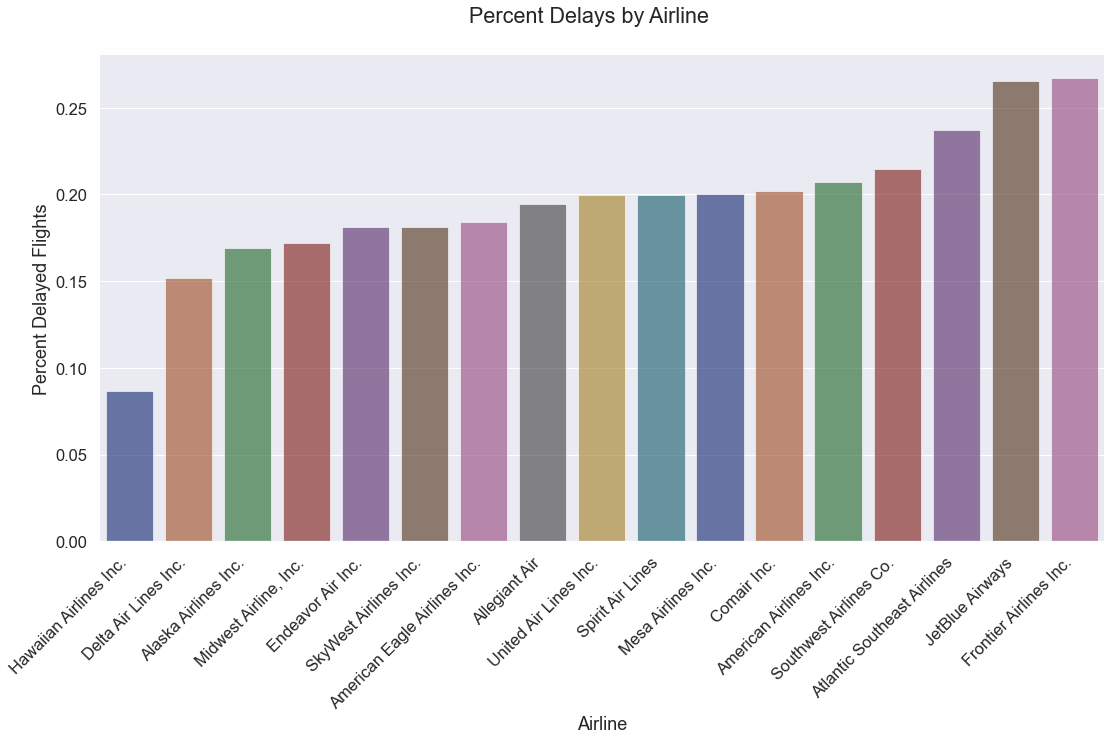

In [16]:
# visualize delay by airline

plot_order = final.groupby('CARRIER_NAME')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="CARRIER_NAME", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2, order=plot_order
)
g.despine(left=True)
g.set_xticklabels(rotation=45, horizontalalignment='right')
g.set_axis_labels("Airline", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Airline", y = 1.05);


In [19]:
# df delay by airline

final.groupby('CARRIER_NAME').mean().sort_values('DEP_DEL15', ascending=False)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
CARRIER_NAME,,,,,,,,,,,,,,,,,,,,,
Frontier Airlines Inc.,0.267296,4.696452,2.894165,22.939541,191.332340,12535.359503,11296.124037,765.467519,1.620501e+06,1857122.0,...,-93.662722,0.097219,0.048170,0.120909,73.582532,8.103593,0.267296,0.198600,0.194515,0.190909
JetBlue Airways,0.265521,4.962780,2.789627,19.203615,138.788612,10006.293553,24650.864743,1897.964693,1.339327e+06,3190369.0,...,-82.911966,0.130774,0.040023,0.052217,70.596307,9.049187,0.265521,0.200760,0.194109,0.194638
Atlantic Southeast Airlines,0.237402,2.454152,2.907511,29.700698,115.546165,11852.455465,10787.406199,1353.265035,1.383400e+06,473794.0,...,-87.251842,0.100707,0.035801,0.110600,72.068417,9.000019,0.237402,0.196619,0.193399,0.199332
Southwest Airlines Co.,0.214405,3.461235,3.456414,18.156123,150.905603,8921.888063,111808.550175,3281.936217,1.143937e+06,13382999.0,...,-98.484728,0.094142,0.029158,0.085968,72.937297,7.951416,0.214405,0.196605,0.194752,0.195116
American Airlines Inc.,0.207231,4.449116,2.588497,32.709310,160.409083,14913.800513,77696.554978,4668.016461,1.805684e+06,11744595.0,...,-91.989765,0.111047,0.022615,0.054581,73.375360,8.250585,0.207231,0.198681,0.194492,0.190291
Comair Inc.,0.201987,2.122452,3.883786,29.467212,76.311704,11846.837249,23735.057090,3870.258015,1.217146e+06,1245396.0,...,-80.666209,0.146309,0.020979,0.067166,71.378261,7.014462,0.201987,0.190066,0.194650,0.199613
Mesa Airlines Inc.,0.200066,2.820889,3.194035,32.862413,75.314221,12487.212391,18550.605282,1732.196144,1.458973e+06,1191889.0,...,-93.725165,0.081984,0.014618,0.049040,76.927391,8.393642,0.200066,0.187587,0.194277,0.198684
Spirit Air Lines,0.199981,4.449923,2.938594,24.975384,182.989591,13054.880368,17091.064421,834.136929,1.692218e+06,2688839.0,...,-90.064260,0.113876,0.023331,0.059354,75.300076,8.182251,0.199981,0.201395,0.194515,0.196905
United Air Lines Inc.,0.199666,5.240472,2.392828,31.288099,158.558322,14159.913615,52363.919214,3325.445157,1.795609e+06,8501631.0,...,-97.114608,0.093460,0.044738,0.105619,70.764656,8.803122,0.199666,0.201886,0.194799,0.192773


In [20]:
# highest delay by grouping of airport and carrier, with a combined count over 50

highest = final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=False)
highest.loc[highest['count'] > 50].head(30)

,,count,mean,std,min,25%,50%,75%,max
DEPARTING_AIRPORT,CARRIER_NAME,,,,,,,,
Newark Liberty International,Frontier Airlines Inc.,237.0,0.493671,0.501018,0.0,0.0,0.0,1.0,1.0
General Mitchell Field,Atlantic Southeast Airlines,235.0,0.476596,0.500518,0.0,0.0,0.0,1.0,1.0
Charleston International,Atlantic Southeast Airlines,203.0,0.448276,0.498547,0.0,0.0,0.0,1.0,1.0
Portland International Jetport,Atlantic Southeast Airlines,88.0,0.443182,0.499608,0.0,0.0,0.0,1.0,1.0
Albany International,JetBlue Airways,249.0,0.421687,0.494824,0.0,0.0,0.0,1.0,1.0
Syracuse Hancock International,Atlantic Southeast Airlines,230.0,0.417391,0.494204,0.0,0.0,0.0,1.0,1.0
Myrtle Beach International,United Air Lines Inc.,193.0,0.414508,0.493918,0.0,0.0,0.0,1.0,1.0
Pensacola Regional,Frontier Airlines Inc.,87.0,0.413793,0.495367,0.0,0.0,0.0,1.0,1.0
Houston Intercontinental,JetBlue Airways,94.0,0.404255,0.493379,0.0,0.0,0.0,1.0,1.0


In [21]:
# df of lowest delay by grouping of airport and carrier, with a combined count over 50

lowest = final.groupby(['DEPARTING_AIRPORT', 'CARRIER_NAME'])['DEP_DEL15'].describe().sort_values('mean', ascending=True)
lowest.loc[lowest['count'] > 50].head(30)

,,count,mean,std,min,25%,50%,75%,max
DEPARTING_AIRPORT,CARRIER_NAME,,,,,,,,
William P Hobby,"Midwest Airline, Inc.",59.0,0.016949,0.130189,0.0,0.0,0.0,0.0,1.0
Lihue Airport,Southwest Airlines Co.,135.0,0.029630,0.170195,0.0,0.0,0.0,0.0,1.0
Keahole,Hawaiian Airlines Inc.,5666.0,0.046770,0.211165,0.0,0.0,0.0,0.0,1.0
Boise Air Terminal,Delta Air Lines Inc.,972.0,0.051440,0.221008,0.0,0.0,0.0,0.0,1.0
Tampa International,Endeavor Air Inc.,171.0,0.058480,0.235337,0.0,0.0,0.0,0.0,1.0
Rochester Monroe County,Delta Air Lines Inc.,924.0,0.062771,0.242681,0.0,0.0,0.0,0.0,1.0
Lihue Airport,Hawaiian Airlines Inc.,5419.0,0.064034,0.244836,0.0,0.0,0.0,0.0,1.0
Truax Field,Delta Air Lines Inc.,1447.0,0.071182,0.257217,0.0,0.0,0.0,0.0,1.0
Eppley Airfield,Alaska Airlines Inc.,265.0,0.071698,0.258476,0.0,0.0,0.0,0.0,1.0


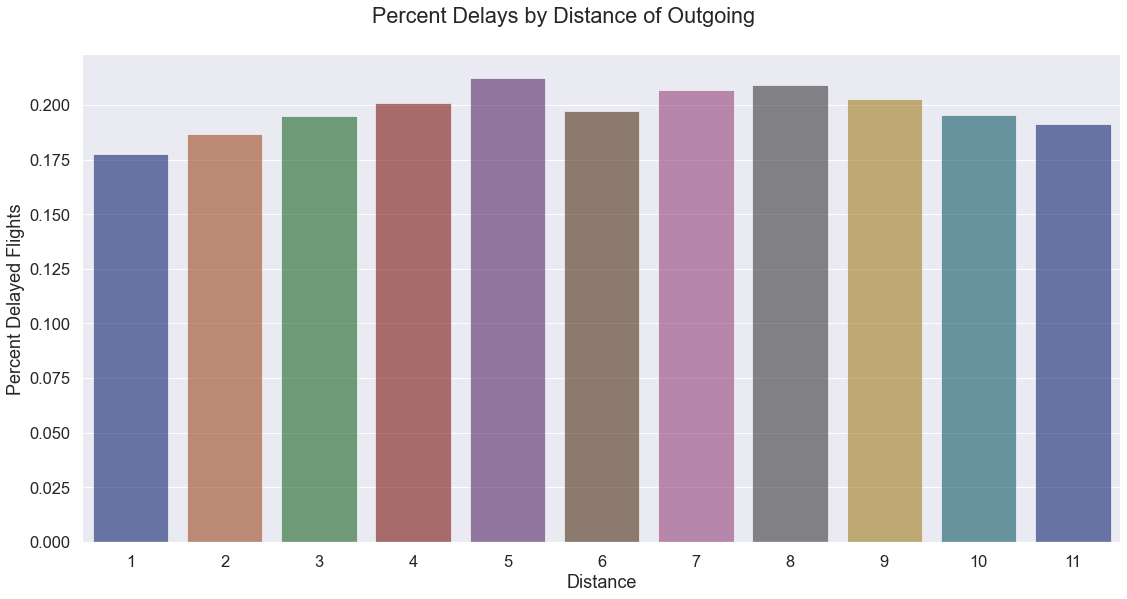

In [22]:
# delays by distance of outgoing flight

g = sns.catplot(
    data=final, kind="bar",
    x="DISTANCE_GROUP", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)

g.set_axis_labels("Distance", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Distance of Outgoing", y = 1.05);


''

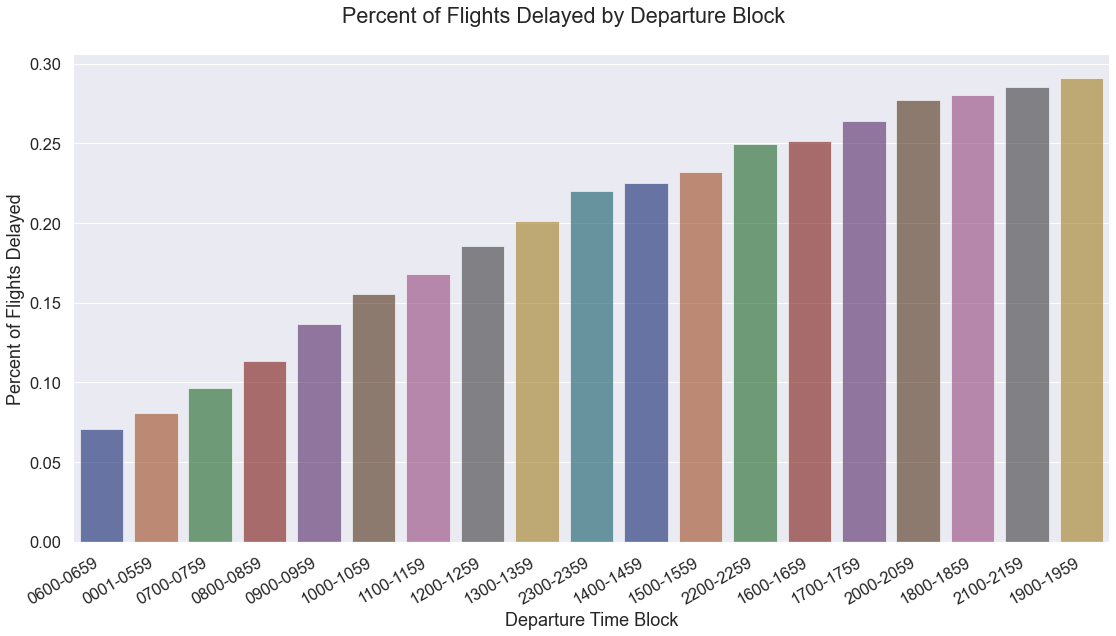

In [19]:
# delay by departure time

plot_order = final.groupby('DEP_TIME_BLK')['DEP_DEL15'].mean().sort_values(ascending=True).index.values

g = sns.catplot(
    data=final, kind="bar",
    x="DEP_TIME_BLK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2,
    order=plot_order
)
g.despine(left=True)

g.set_axis_labels("Departure Time Block", "Percent of Flights Delayed")
g.set_xticklabels(rotation=30, horizontalalignment='right')
g.fig.suptitle("Percent of Flights Delayed by Departure Block", y = 1.05);

# save figure to png
plt.savefig('images/dep_delay.png', bbox_inches='tight')
;

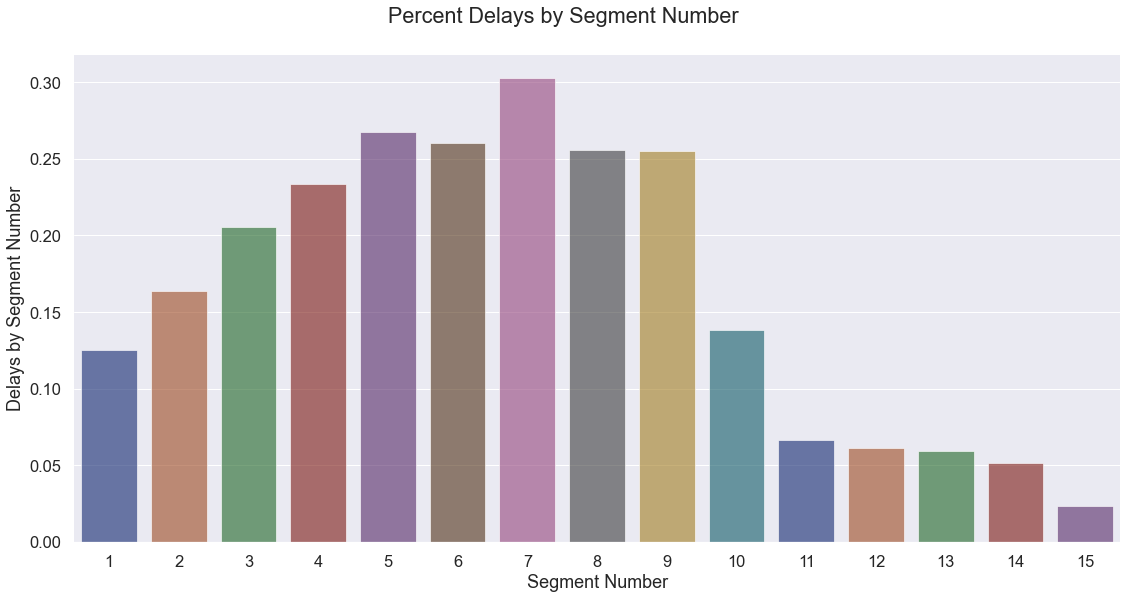

In [24]:
# delay by segment number

g = sns.catplot(
    data=final, kind="bar",
    x="SEGMENT_NUMBER", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Segment Number", "Delays by Segment Number")
g.fig.suptitle("Percent Delays by Segment Number", y = 1.05);


''

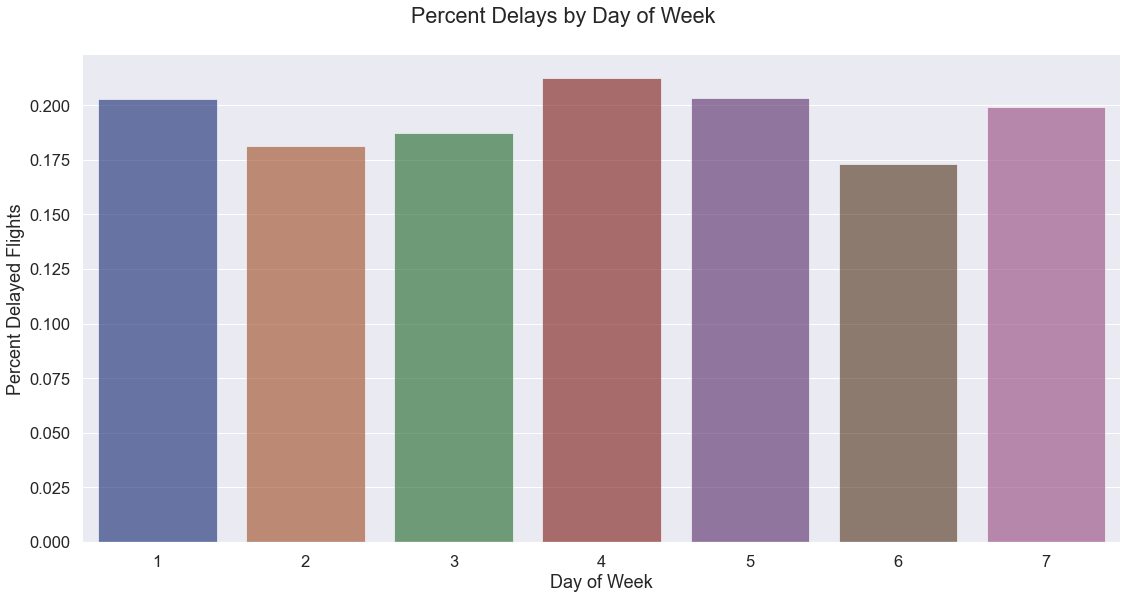

In [25]:
# delay by day of week

g = sns.catplot(
    data=final, kind="bar",
    x="DAY_OF_WEEK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)

g.set_axis_labels("Day of Week", "Percent Delayed Flights")
g.fig.suptitle("Percent Delays by Day of Week", y = 1.05)
;

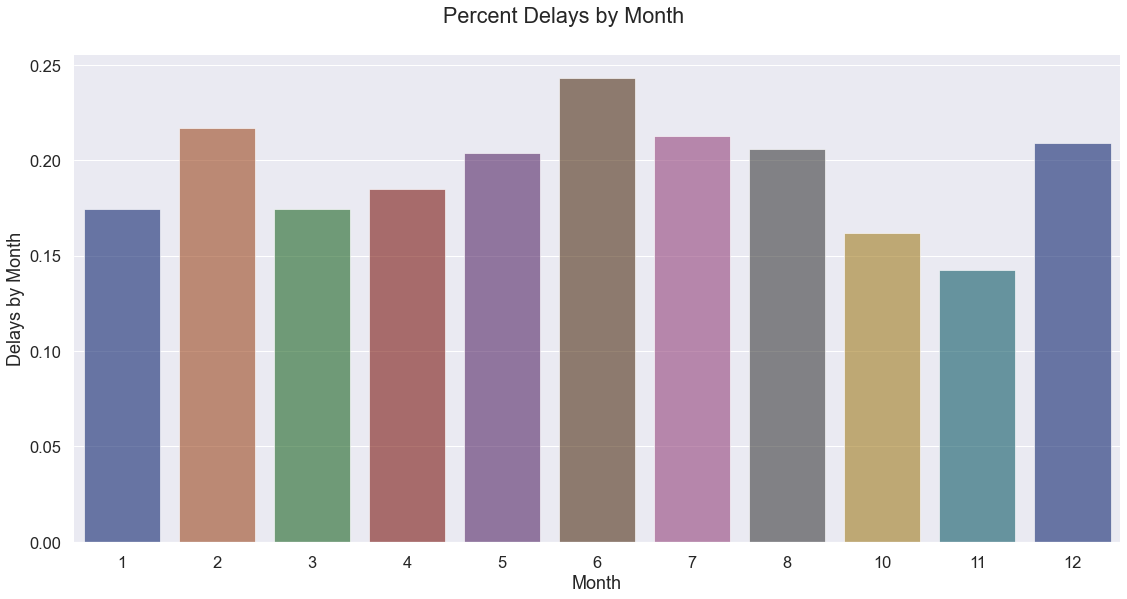

In [26]:
# delay by month

g = sns.catplot(
    data=final, kind="bar",
    x="MONTH", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Delays by Month")

g.fig.suptitle("Percent Delays by Month", y = 1.05);


In [13]:
# Drop categoricals that we were using for our visualizations 

final.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

## Correlations

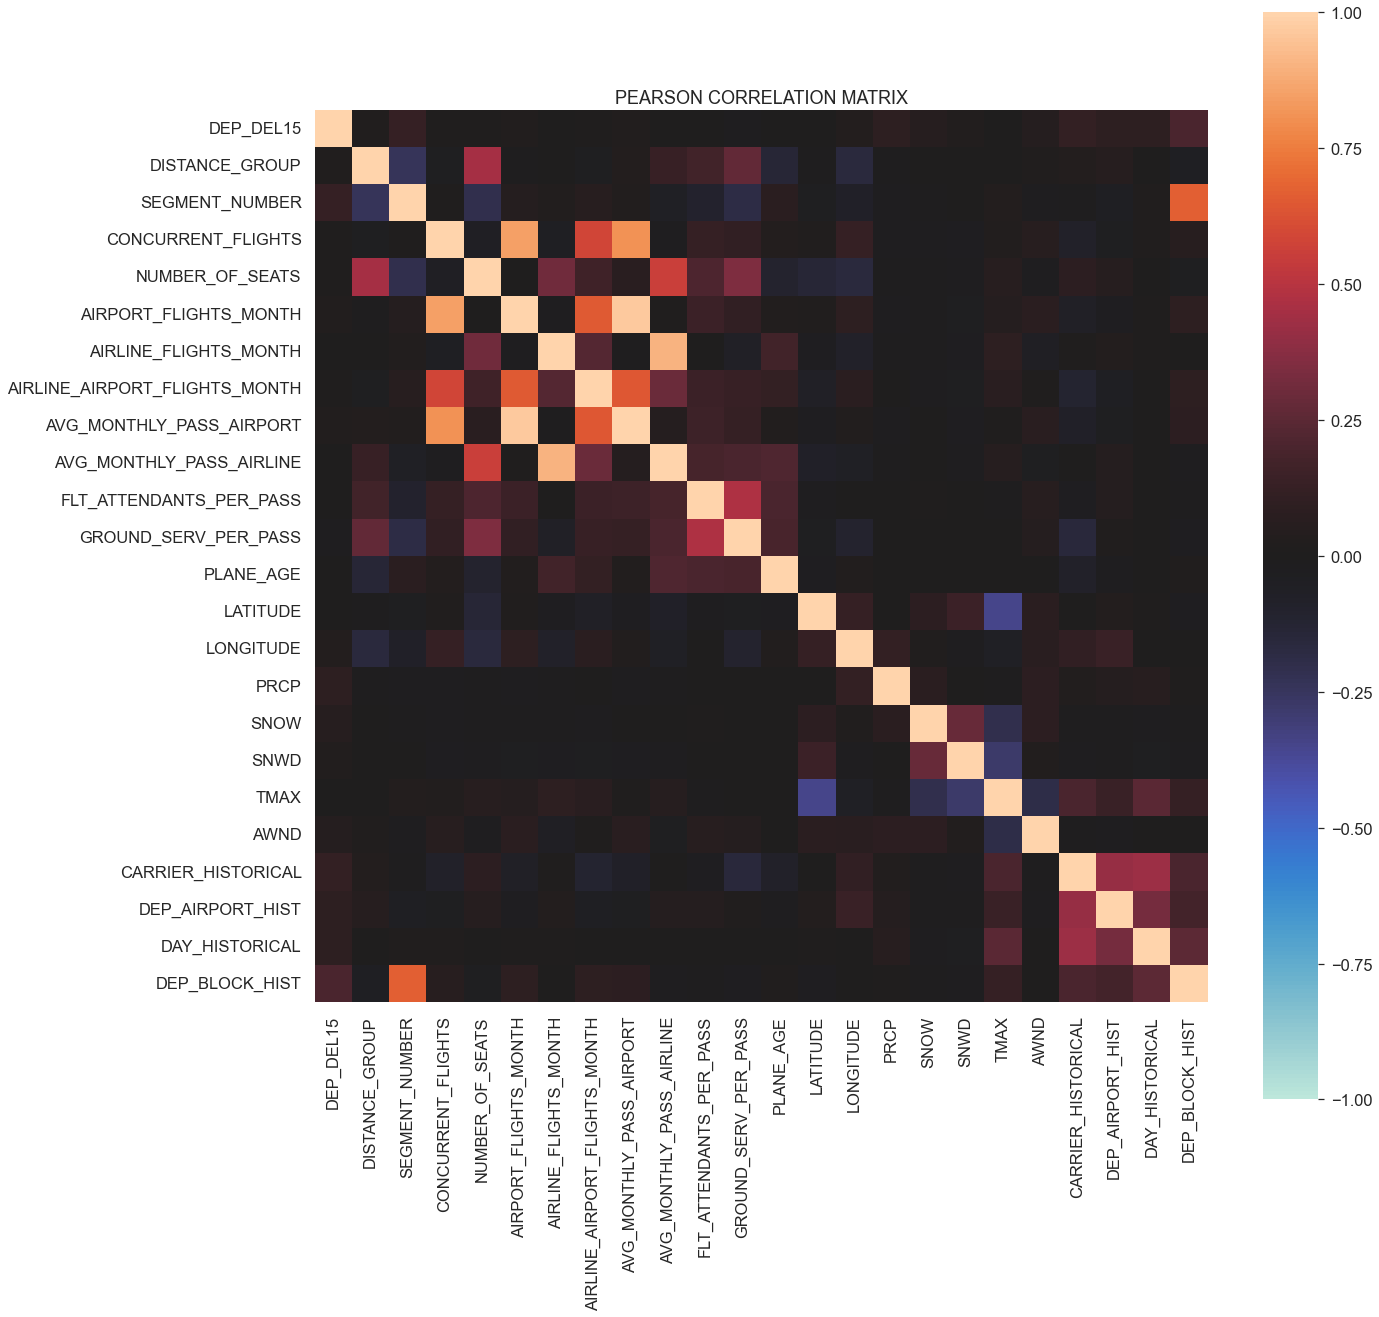

In [28]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [29]:
final.corr()

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DEP_DEL15,1.000000,0.015953,0.119982,0.008706,0.012773,0.026519,0.001382,0.014120,0.024782,0.000546,...,0.032165,0.086416,0.048051,0.024111,0.003216,0.044763,0.115107,0.093441,0.089561,0.198474
DISTANCE_GROUP,0.015953,1.000000,-0.237705,-0.034587,0.448600,-0.012680,-0.002992,-0.034250,0.037867,0.127440,...,-0.160583,-0.014216,-0.001021,-0.007733,0.004710,0.021918,0.036199,0.047932,0.002181,-0.039120
SEGMENT_NUMBER,0.119982,-0.237705,1.000000,0.013189,-0.203532,0.042036,0.027518,0.056048,0.025082,-0.057694,...,-0.072276,-0.019189,-0.014744,-0.007251,0.031384,-0.023232,-0.013318,-0.046520,0.020816,0.669615
CONCURRENT_FLIGHTS,0.008706,-0.034587,0.013189,1.000000,-0.053233,0.850388,-0.040403,0.584052,0.811012,-0.016681,...,0.117896,-0.020370,-0.017700,-0.027285,0.025770,0.061221,-0.080179,-0.037416,0.021186,0.057637
NUMBER_OF_SEATS,0.012773,0.448600,-0.203532,-0.053233,1.000000,0.004189,0.306448,0.160401,0.063034,0.555860,...,-0.162859,-0.015120,-0.008757,-0.015691,0.059685,-0.020030,0.081882,0.054114,-0.003668,-0.036392
AIRPORT_FLIGHTS_MONTH,0.026519,-0.012680,0.042036,0.850388,0.004189,1.000000,-0.017168,0.649108,0.968213,0.013922,...,0.089729,-0.016769,-0.011038,-0.033285,0.043861,0.071650,-0.067412,-0.029789,0.009795,0.090419
AIRLINE_FLIGHTS_MONTH,0.001382,-0.002992,0.027518,-0.040403,0.306448,-0.017168,1.000000,0.231677,-0.008064,0.902411,...,-0.079112,-0.012225,-0.013773,-0.025763,0.086987,-0.050439,0.012005,0.034978,0.010215,0.000364
AIRLINE_AIRPORT_FLIGHTS_MONTH,0.014120,-0.034250,0.056048,0.584052,0.160401,0.649108,0.231677,1.000000,0.643742,0.289704,...,0.071248,-0.002873,-0.020124,-0.033055,0.068850,0.008679,-0.114397,-0.040327,0.004880,0.092507
AVG_MONTHLY_PASS_AIRPORT,0.024782,0.037867,0.025082,0.811012,0.063034,0.968213,-0.008064,0.643742,1.000000,0.041427,...,0.028540,-0.019563,-0.004668,-0.025515,0.011968,0.070298,-0.076918,-0.036114,0.001334,0.084585
AVG_MONTHLY_PASS_AIRLINE,0.000546,0.127440,-0.057694,-0.016681,0.555860,0.013922,0.902411,0.289704,0.041427,1.000000,...,-0.057130,-0.007912,-0.006974,-0.018317,0.049225,-0.034521,0.004741,0.046616,0.001000,-0.017567


In [30]:
#Get our list of highly correlated feature pairs:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 95% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(AVG_MONTHLY_PASS_AIRLINE, AIRLINE_FLIGHTS_MONTH)",AVG_MONTHLY_PASS_AIRLINE,AIRLINE_FLIGHTS_MONTH,0.902411
"(AIRLINE_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRLINE)",AIRLINE_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,0.902411
"(CONCURRENT_FLIGHTS, AIRPORT_FLIGHTS_MONTH)",CONCURRENT_FLIGHTS,AIRPORT_FLIGHTS_MONTH,0.850388
"(AIRPORT_FLIGHTS_MONTH, CONCURRENT_FLIGHTS)",AIRPORT_FLIGHTS_MONTH,CONCURRENT_FLIGHTS,0.850388
"(CONCURRENT_FLIGHTS, AVG_MONTHLY_PASS_AIRPORT)",CONCURRENT_FLIGHTS,AVG_MONTHLY_PASS_AIRPORT,0.811012
"(AVG_MONTHLY_PASS_AIRPORT, CONCURRENT_FLIGHTS)",AVG_MONTHLY_PASS_AIRPORT,CONCURRENT_FLIGHTS,0.811012


In [14]:
# drop highly correlated features
final.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

In [32]:
# Check out our variables correlationg with delay
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)

,level_0,level_1,0
0,DEP_DEL15,DEP_DEL15,1.000000
20,DEP_DEL15,DEP_BLOCK_HIST,0.198474
2,DEP_DEL15,SEGMENT_NUMBER,0.119982
17,DEP_DEL15,CARRIER_HISTORICAL,0.115107
18,DEP_DEL15,DEP_AIRPORT_HIST,0.093441
19,DEP_DEL15,DAY_HISTORICAL,0.089561
12,DEP_DEL15,PRCP,0.086416
13,DEP_DEL15,SNOW,0.048051
16,DEP_DEL15,AWND,0.044763
11,DEP_DEL15,LONGITUDE,0.032165


In [33]:
visual_correl = df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)
visual_correl.drop('level_0', inplace=True, axis=1)
visual_correl.drop(0, inplace=True, axis=0)
visual_correl.reset_index(inplace=True, drop=True)
items = list(visual_correl['level_1'].unique())
replacements = ['Departure Block', 'Segment Number', 'Carrier Delay', 'Airport Delay', 'Day Delay', 'Precipitation',
                   'Snowfall', 'Wind Speed', 'Longitude', 'Ground Snow', 'Customer Service per Pass', 'Flight Distance',
                   'Flights/Month for Airline and Airport', 'Number of Seats', 'Concurrent Outgoing', 'Plane Age',
               'Max Temp', 'Flight Attendants per Pass', 'Airline Flights per Month', 'Latitude']
visual_correl['level_1'].replace(items, replacements, inplace=True)


visual_correl

,level_1,0
0,Departure Block,0.198474
1,Segment Number,0.119982
2,Carrier Delay,0.115107
3,Airport Delay,0.093441
4,Day Delay,0.089561
5,Precipitation,0.086416
6,Snowfall,0.048051
7,Wind Speed,0.044763
8,Longitude,0.032165
9,Ground Snow,0.024111


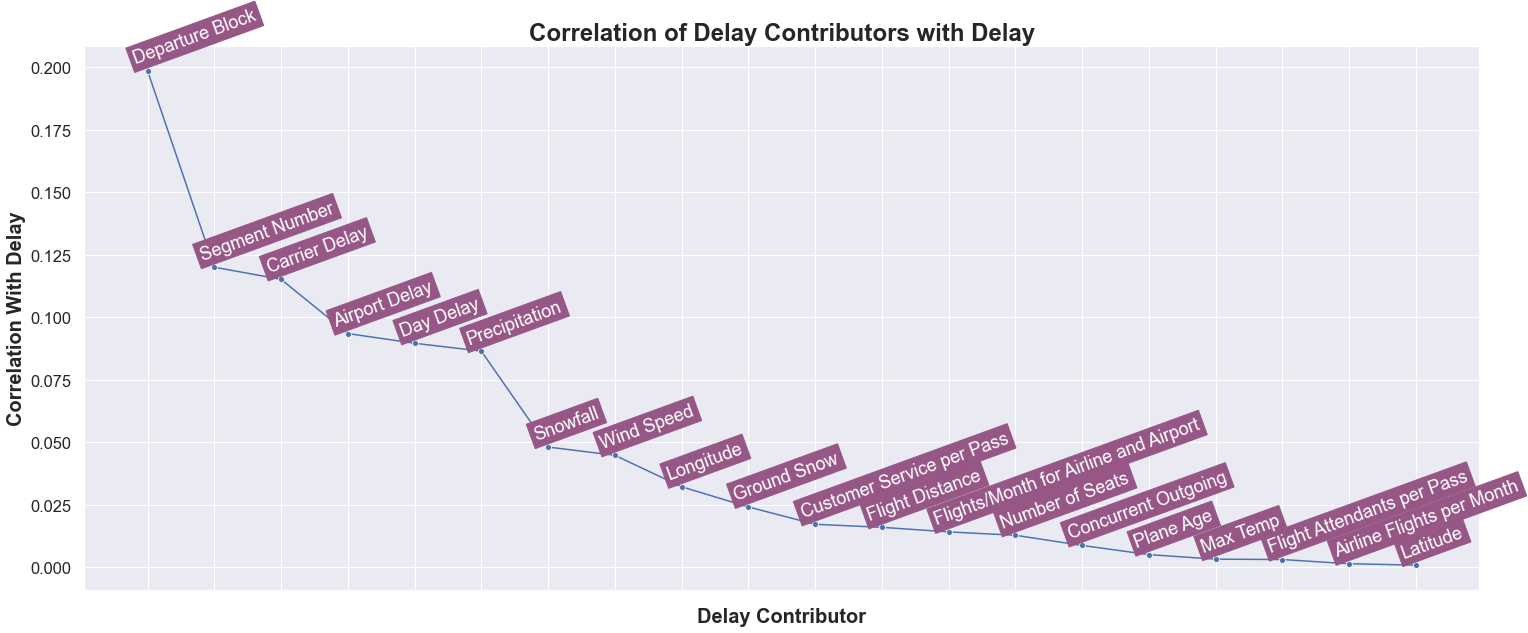

In [34]:
# prepare our figure size and scale
sns.set(rc={'figure.figsize':(25,10)}, font_scale = 1.5)

# set our lineplot
scatter5 = sns.lineplot(x=visual_correl['level_1'], y=visual_correl[0], data=visual_correl, marker='o', palette='bright')

# label points on the plot
for x, y, z in zip(np.arange(0, 20, step=1), visual_correl['level_1'], visual_correl[0]):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(x = x-.25, # x-coordinate position of data label
        y = z+.003, # y-coordinate position of data label
        s = '{}'.format(y), # data label
        rotation = 20,
        color = 'white').set_backgroundcolor('#965786') # set colour of line

# hide the x ticks 
scatter5.axes.xaxis.set_ticklabels([])

# label our figure

scatter5.set_ylabel('Correlation With Delay',weight='bold',fontsize=20)
scatter5.set_xlabel('Delay Contributor', weight='bold',fontsize=20)
scatter5.set_title('Correlation of Delay Contributors with Delay',weight='bold',fontsize=24);

#plt.savefig('images/delay_contributors.png')

# Modeling

In [15]:
# prepare dictionary to store testing results

randomstate=42

spot_check = {}
spot_check['Model'] = []
spot_check['f1'] = []
spot_check['accuracy'] = []
spot_check['auc'] = []
spot_check['precision'] = []
spot_check['recall'] = []
spot_check['time'] = []


models = {}
models['Model'] = []
models['f1'] = []
models['accuracy'] = []
models['auc'] = []
models['precision'] = []
models['recall'] = []
models['time'] = []

## PreProcessing

In [16]:
# Make x-train and y-train
x_train = final.drop('DEP_DEL15', axis=1)
y_train = final['DEP_DEL15']

In [17]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test.pkl')

x_val = val.drop('DEP_DEL15', axis=1)
y_val = val['DEP_DEL15']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

### Processing Pipelines

In [18]:
# set up processing categories

features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

poly_features = ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST']

features_cat, cont_features, poly_features

([],
 ['DISTANCE_GROUP',
  'SEGMENT_NUMBER',
  'CONCURRENT_FLIGHTS',
  'NUMBER_OF_SEATS',
  'AIRLINE_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'FLT_ATTENDANTS_PER_PASS',
  'GROUND_SERV_PER_PASS',
  'PLANE_AGE',
  'LATITUDE',
  'LONGITUDE',
  'PRCP',
  'SNOW',
  'SNWD',
  'TMAX',
  'AWND',
  'CARRIER_HISTORICAL',
  'DEP_AIRPORT_HIST',
  'DAY_HISTORICAL',
  'DEP_BLOCK_HIST'],
 ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST'])

In [19]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [20]:
# delete variables that we aren't using anymore
del [final, x_train, x_val]

Using the framework proposed at https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/

Model Plans:

Linear Algorithms: 
* Logistic Regression
* Naive Bayes

Nonlinear Algorithms: 
* Decision Trees
* SVM (Could not use - see "Unused Methods")
* KNN (Could not use - see "Unused Methods")

Ensemble Algorithms: 
* Extra Trees
* Random Forest
* XGBoost
* CatBoost
* AdaBoost
* Gradient Boosted Trees

Feature Selection Plans:

* Remove High Correlations (Already completed)
* Permutation Importance

### Determine required data to train model

The Learning Curve will tell us if we can use less than our full dataset of millions of rows to train our model.

In [21]:
# get balance ratio of y for algorithms that require an input ratio
counts = Counter(y_train)
scale_weight = counts[0]/counts[1]

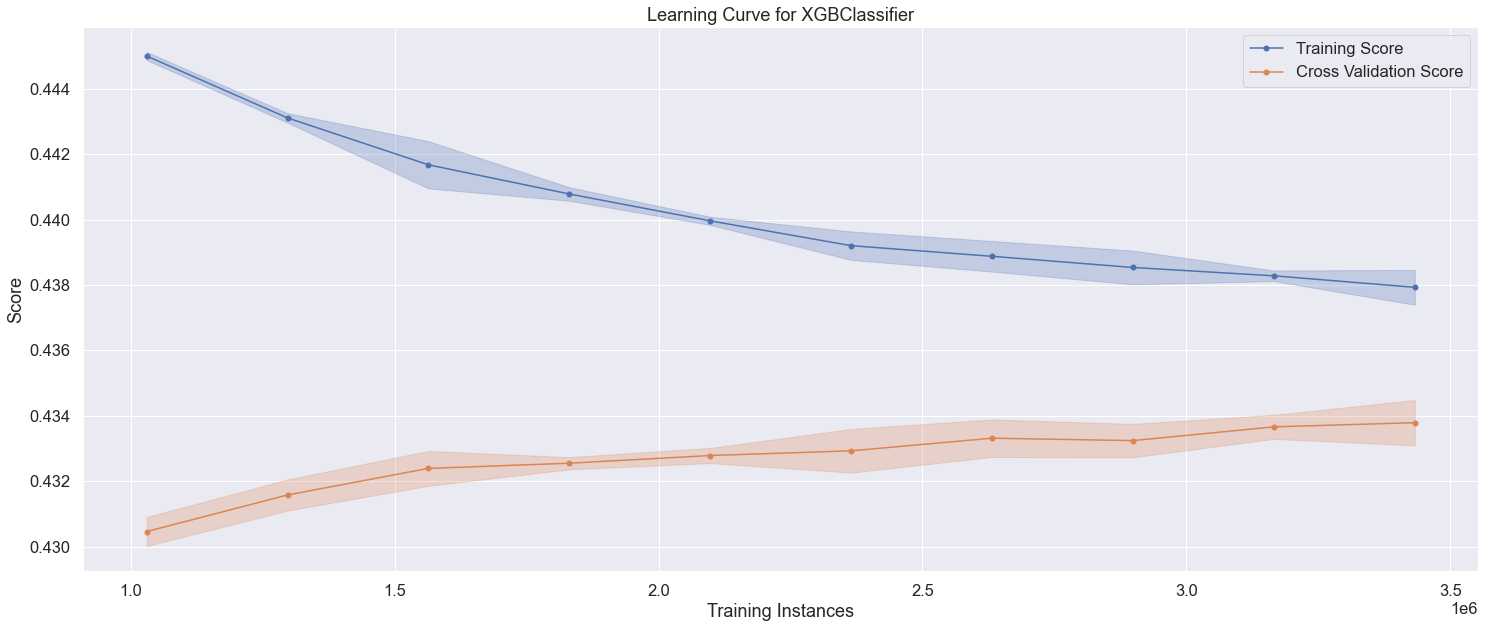

In [42]:
cv = StratifiedKFold(n_splits=4)
sizes = np.linspace(0.3, 1.0, 10)

model = XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(processed_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure

In [43]:
# delete memory sucking variables that we won't use again
del [visualizer, model]

We'll be using all our data to work with our model. At least for some models, this results in improved CV scores.

## Spot Check Baseline Algorithms

We will run the basic algorithms with no hyperparameter tuning, to get a feel for their baseline performance.

For computational cost reasons, we are going to spot check all of our algorithms on a MUCH smaller train set. Once we have a firm idea of what might work, we'll select the top algorithms and train those on our larger data set.

In [22]:
# Make smaller sets to spot check different algorithms
# Looking to get two sets of about 400k records

x_break, x_discard, y_break, y_discard = train_test_split(processed_train, y_train, test_size=.85, random_state=randomstate, stratify=y_train)
x_sample, x_rest, y_sample, y_rest = train_test_split(x_break, y_break, test_size=.5, random_state=randomstate, stratify=y_break)

In [45]:
# Set up baseline models
baseline_models = {
    "Logistic Regression": LogisticRegression(random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Extra Trees" : ExtraTreesClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "XGBoost": XGBClassifier(verbosity=0, n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=False, task_type='GPU', devices='0:1'),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

# run spot check on each model in baseline
for model in baseline_models:
    this_model = baseline_models[model]
    label = model
    spot_check = spot_check_classifier(this_model, x_sample, y_sample, label, x_rest, y_rest, spot_check)



Running Logistic Regression Classification
CV 5 Accuracy Train Score: 59.08
CV 5 F1 Train Score: 39.08
CV 5 Auc Train Score: 67.04
CV 5 Precision Train Score: 27.52
CV 5 Recall Train Score: 67.36

Validation Accuracy ( 0.5 Thresh)):  0.5921149605427591
Validation f1 Score ( 0.5 Thresh):  0.3919628976646025
Validation AUC Score ( 0.5 Thresh):  0.6234481265189128
Validation Precision Score ( 0.5 Thresh):  0.27619951040391677
Validation Recall Score ( 0.5 Thresh):  0.6747854430190485 

              precision    recall  f1-score   support

           0       0.88      0.57      0.69    276401
           1       0.28      0.67      0.39     66882

    accuracy                           0.59    343283
   macro avg       0.58      0.62      0.54    343283
weighted avg       0.76      0.59      0.63    343283

Elapsed Time: 41.60332703590393


Running Naive Bayes Classification
CV 5 Accuracy Train Score: 75.02
CV 5 F1 Train Score: 31.07
CV 5 Auc Train Score: 65.69
CV 5 Precision Train Score

## Spot-Check Imbalanced Algorithms

Spot check the same baseline algorithms, but after using various balancing methods, both on the data directly and with class_weight

### Cost-Balanced class weights

In [46]:
# set up weighted/balanced models
weighted_models = {
    "Logistic Regression_Weighted": LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}

# spot check weighted models
for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check = spot_check_classifier(this_model, x_sample, y_sample, label, x_rest, y_rest, spot_check)



Running Logistic Regression_Weighted Classification
CV 5 Accuracy Train Score: 56.57
CV 5 F1 Train Score: 38.96
CV 5 Auc Train Score: 67.23
CV 5 Precision Train Score: 26.83
CV 5 Recall Train Score: 71.15

Validation Accuracy ( 0.5 Thresh)):  0.5677152669954527
Validation f1 Score ( 0.5 Thresh):  0.39129079364037606
Validation AUC Score ( 0.5 Thresh):  0.6228317928945527
Validation Precision Score ( 0.5 Thresh):  0.26961211038630684
Validation Recall Score ( 0.5 Thresh):  0.7131365688825095 

              precision    recall  f1-score   support

           0       0.88      0.53      0.66    276401
           1       0.27      0.71      0.39     66882

    accuracy                           0.57    343283
   macro avg       0.58      0.62      0.53    343283
weighted avg       0.76      0.57      0.61    343283

Elapsed Time: 43.87789964675903


Running Decision Tree Classifier_Weighted Classification
CV 5 Accuracy Train Score: 72.34
CV 5 F1 Train Score: 28.8
CV 5 Auc Train Score: 5

In [47]:
# Check model scores chart so far

chart = pd.DataFrame(spot_check)
chart.sort_values('recall', ascending=False)

,Model,f1,accuracy,auc,precision,recall,time
9,Logistic Regression_Weighted,0.391291,0.567715,0.622832,0.269612,0.713137,43.877900
0,Logistic Regression,0.391963,0.592115,0.623448,0.276200,0.674785,41.603327
13,Balanced Random Forest,0.419917,0.643452,0.650624,0.307396,0.662376,33.589550
15,CatBoost_Weighted,0.422210,0.658623,0.651635,0.314968,0.640187,69.798494
14,XGBoost_Weighted,0.425337,0.672766,0.653363,0.323276,0.621572,39.950821
2,Decision Tree,0.306137,0.717481,0.566790,0.293516,0.319892,30.521752
10,Decision Tree Classifier_Weighted,0.295230,0.725859,0.562449,0.295748,0.294713,28.964336
1,Naive Bayes,0.311260,0.750856,0.575790,0.337295,0.288957,4.077716
3,Extra Trees,0.228002,0.801135,0.554622,0.467861,0.150728,64.795923
4,Random Forest,0.227000,0.810017,0.557276,0.547575,0.143178,57.707470


## Further Check Top Algorithms

### Data Undersampling

The 6.5 million row combined dataset is a lot of data for a system to handle. We will reduce this to a more manageable data set by undersampling the majority class to match the minority class.

In doing so we will turn this into a balanced classification problem, with an equal ratio for the target.

TomekLinks - closest pairs of opposite classification neighbors. The majority class of these pairs is removed. TomekLinks gets rid of noisy/ambiguous data.

RandomUnderSampler - Picks majority samples to use entirely at random


In [48]:
# define balanced models to check resampling

xgbc = XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1)
catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1')
forest = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1)
log = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1)
decision_tree = DecisionTreeClassifier(random_state=randomstate)

##### Method 1 - TomekLinks 

These look for differently classified pairs of data where the data is very similar but the labels are different. It elminates the majority instance in these pairs. This helps the dataset remove noisy or ambiguous data.

In [49]:
tl = TomekLinks(sampling_strategy='majority', n_jobs=-1)
x_tl, y_tl = tl.fit_resample(x_sample, y_sample)

In [50]:
# spot check our TomekLinks with various balanced models

spot_check = spot_check_classifier(xgbc, x_tl, y_tl, "XGBoost_Weighted_TomekLinks", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, x_tl, y_tl, "CatBoost_Weighted_TomekLinks", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(forest, x_tl, y_tl, "Balanced_Forest_TomekLinks", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(log, x_tl, y_tl, "LogReg_Weighted_TomekLinks", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, x_tl, y_tl, "DecisionTree_TomekLinks", x_rest, y_rest, spot_check)

del [tl, x_tl, y_tl]



Running XGBoost_Weighted_TomekLinks Classification
CV 5 Accuracy Train Score: 66.11
CV 5 F1 Train Score: 44.81
CV 5 Auc Train Score: 72.22
CV 5 Precision Train Score: 33.88
CV 5 Recall Train Score: 66.16

Validation Accuracy ( 0.5 Thresh)):  0.646236487096652
Validation f1 Score ( 0.5 Thresh):  0.42357330346166444
Validation AUC Score ( 0.5 Thresh):  0.6541554589065126
Validation Precision Score ( 0.5 Thresh):  0.3102915916187403
Validation Recall Score ( 0.5 Thresh):  0.6671301695523459 

              precision    recall  f1-score   support

           0       0.89      0.64      0.74    276401
           1       0.31      0.67      0.42     66882

    accuracy                           0.65    343283
   macro avg       0.60      0.65      0.58    343283
weighted avg       0.78      0.65      0.68    343283

Elapsed Time: 37.29993176460266


Running CatBoost_Weighted_TomekLinks Classification
CV 5 Accuracy Train Score: 66.81
CV 5 F1 Train Score: 44.63
CV 5 Auc Train Score: 72.03
CV

##### Method 2 - Random Under Sampler

This makes the majority samples equal to the minority samples by randomly removing samples.

This is a risky method because it removes a lot of real data, but it might work on a data set with as many samples as ours.

In [51]:
# Set up RandomUnderSampler

rus = RandomUnderSampler(random_state=randomstate, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(x_sample, y_sample)

In [52]:
# spot check RUS with different classifiers

spot_check = spot_check_classifier(xgbc, x_rus, y_rus, "XGBoost_Weighted_RandomUnderSampler", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, x_rus, y_rus, "CatBoost_Weighted_RUS", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(forest, x_rus, y_rus, "Balanced_Forest_RUS", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(log, x_rus, y_rus, "LogReg_Weighted_RUS", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, x_rus, y_rus, "DecisionTree_RUS", x_rest, y_rest, spot_check)

del [rus, x_rus, y_rus]



Running XGBoost_Weighted_RandomUnderSampler Classification
CV 5 Accuracy Train Score: 54.28
CV 5 F1 Train Score: 67.99
CV 5 Auc Train Score: 70.53
CV 5 Precision Train Score: 52.3
CV 5 Recall Train Score: 97.13

Validation Accuracy ( 0.5 Thresh)):  0.27333424608850426
Validation f1 Score ( 0.5 Thresh):  0.343364201593076
Validation AUC Score ( 0.5 Thresh):  0.5393371242591092
Validation Precision Score ( 0.5 Thresh):  0.2083658134512415
Validation Recall Score ( 0.5 Thresh):  0.9751652163511857 

              precision    recall  f1-score   support

           0       0.95      0.10      0.19    276401
           1       0.21      0.98      0.34     66882

    accuracy                           0.27    343283
   macro avg       0.58      0.54      0.26    343283
weighted avg       0.80      0.27      0.22    343283

Elapsed Time: 16.48199486732483


Running CatBoost_Weighted_RUS Classification
CV 5 Accuracy Train Score: 64.85
CV 5 F1 Train Score: 64.64
CV 5 Auc Train Score: 70.72
CV

### Data Oversampling

SMOTE creates synthetic data from the minority class, adding minor variations so that it is not simply duplicates of minority data.

In [53]:
# Set up SMOTE

smote = SMOTE(n_jobs=-1)
processed_train_resampled, y_train_resampled = smote.fit_resample(x_sample, y_sample) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())

-----------------------------------------
Synthetic sample class distribution: 

1    276400
0    276400
Name: DEP_DEL15, dtype: int64


In [54]:
# Spot check SMOTE with different classifiers

spot_check = spot_check_classifier(xgbc, processed_train_resampled, y_train_resampled, "XGBoost_Weighted_SMOTE", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, processed_train_resampled, y_train_resampled, "CatBoost_Weighted_SMOTE", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(forest, processed_train_resampled, y_train_resampled, "Balanced_Forest_SMOTE", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(log, processed_train_resampled, y_train_resampled, "LogReg_Weighted_SMOTE", x_rest, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, processed_train_resampled, y_train_resampled, "DecisionTree_SMOTE", x_rest, y_rest, spot_check)

del [smote, processed_train_resampled, y_train_resampled]



Running XGBoost_Weighted_SMOTE Classification
CV 5 Accuracy Train Score: 71.02
CV 5 F1 Train Score: 68.77
CV 5 Auc Train Score: 92.19
CV 5 Precision Train Score: 69.37
CV 5 Recall Train Score: 81.73

Validation Accuracy ( 0.5 Thresh)):  0.6140298237897012
Validation f1 Score ( 0.5 Thresh):  0.4097208918985143
Validation AUC Score ( 0.5 Thresh):  0.6418908320692202
Validation Precision Score ( 0.5 Thresh):  0.29180812651110843
Validation Recall Score ( 0.5 Thresh):  0.6875392482282229 

              precision    recall  f1-score   support

           0       0.89      0.60      0.71    276401
           1       0.29      0.69      0.41     66882

    accuracy                           0.61    343283
   macro avg       0.59      0.64      0.56    343283
weighted avg       0.77      0.61      0.65    343283

Elapsed Time: 77.6125693321228


Running CatBoost_Weighted_SMOTE Classification
CV 5 Accuracy Train Score: 86.57
CV 5 F1 Train Score: 76.37
CV 5 Auc Train Score: 92.36
CV 5 Precisi

### Unused Methods


##### Unused Models

K-Nearest Neighbors and Support Vector Machine proved to be too computationally expensive to include as models. KNN requires accessing the entire dataset to determine neighbors for each individual point. SVM is known to be too slow with large datasets. Both of these models were attempted multiple times and discarded after significant time investment.

##### Unused Under/Oversampling Methods

A desire existed to use a few different combination oversampling and undersampling methods. In particular I wanted to try One Sided Selection and Condensed Nearest Neighbor. 

TomekLinks + Condensed Nearest Neighbor = OneSidedSelection
    - One step process. Identifies TomekLinks, which are closest pairs of opposite classification neighbors. The majority class of these pairs is removed. CNN then gets rid of redundant majority class examples that are far from the class boundary. When used together, TomekLinks gets rid of noisy/ambiguous data, and then CNN gets rid of redundant but decisive majority data.

Condensed Nearest Neighbor + Edited Nearest Neighbor = NeighbourhoodCleaning Rule
    - This process does CNN first (rather than second like OneSided). Redundant but decisive majority data is removed. Then ENN removes the noisy/ambiguous examples using a K-Nearest Neighbors algorithm with default of 3 neighbors. This method usually results in less cut data. 

After this removal process, both are used with SMOTE to oversample the minority data.

Unfortunately our data set was too large and the computational cost of these methods was too high, specifically because they both rely on a KNN algorithm to make neighborhood selections.

## Feature Selection

### Permutation Importance

Permutation Importance randomly shuffles the data in a feature, then re-fits and re-scores the model. It turns the feature into noise by shuffling, and then in re-scoring asseses the impact the model. Features of high importance will create more model error when shuffled.

In [55]:
xgbc.fit(x_sample, y_sample)

r = permutation_importance(xgbc, x_sample, y_sample,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0.001:
        print(f"{x_sample.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")
        
importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] > 0.001:
        importances[x_sample.columns[i]] = r.importances_mean[i]
    else: continue
        
print(importances)

important_features = list(importances.keys())
print(important_features)

DEP_BLOCK_HIST 		Importance: 0.134 
SEGMENT_NUMBER 		Importance: 0.130 
PRCP     		Importance: 0.014 
TMAX     		Importance: 0.013 
AIRLINE_AIRPORT_FLIGHTS_MONTH 		Importance: 0.012 
CONCURRENT_FLIGHTS 		Importance: 0.012 
PLANE_AGE 		Importance: 0.011 
LONGITUDE 		Importance: 0.010 
DEP_AIRPORT_HIST 		Importance: 0.010 
NUMBER_OF_SEATS 		Importance: 0.009 
CARRIER_HISTORICAL 		Importance: 0.009 
DAY_HISTORICAL 		Importance: 0.008 
DISTANCE_GROUP 		Importance: 0.006 
LATITUDE 		Importance: 0.006 
AWND     		Importance: 0.006 
FLT_ATTENDANTS_PER_PASS 		Importance: 0.004 
GROUND_SERV_PER_PASS 		Importance: 0.003 
AIRLINE_FLIGHTS_MONTH 		Importance: 0.003 
{'DEP_BLOCK_HIST': 0.13359162437879057, 'SEGMENT_NUMBER': 0.1299320480926274, 'PRCP': 0.01367505432851126, 'TMAX': 0.012676652625732381, 'AIRLINE_AIRPORT_FLIGHTS_MONTH': 0.012095789079143859, 'CONCURRENT_FLIGHTS': 0.011822544341581158, 'PLANE_AGE': 0.010589350252367824, 'LONGITUDE': 0.010372424614942425, 'DEP_AIRPORT_HIST': 0.0099484777

In [23]:
# re-iterating the important permuted features so that we don't have to run the above block ever time

important_features = ['DEP_BLOCK_HIST', 'SEGMENT_NUMBER', 'PLANE_AGE', 'NUMBER_OF_SEATS', 'PRCP', 
                      'CONCURRENT_FLIGHTS', 'LONGITUDE', 'DEP_AIRPORT_HIST', 'TMAX', 'LATITUDE', 
                      'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'FLT_ATTENDANTS_PER_PASS', 'CARRIER_HISTORICAL', 
                      'DISTANCE_GROUP', 'AWND', 'DAY_HISTORICAL', 'AIRLINE_FLIGHTS_MONTH']

In [57]:
permutation_x_train = x_sample[important_features]
permutation_x_test = x_rest[important_features]

In [58]:
# spot check our models with permutation importance

spot_check = spot_check_classifier(xgbc, permutation_x_train, y_sample, 'XGBoost_Weighted w/Permutation Importance', permutation_x_test, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, permutation_x_train, y_sample, "CatBoost_Weighted_w/Permutation Importance", permutation_x_test, y_rest, spot_check)
spot_check = spot_check_classifier(forest, permutation_x_train, y_sample, "Balanced_Forest_w/Permutation Importance", permutation_x_test, y_rest, spot_check)
spot_check = spot_check_classifier(log, permutation_x_train, y_sample, "LogReg_Weighted_w/Permutation Importance", permutation_x_test, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, permutation_x_train, y_sample, "DecisionTree_w/Permutation Importance", permutation_x_test, y_rest, spot_check)



Running XGBoost_Weighted w/Permutation Importance Classification
CV 5 Accuracy Train Score: 67.12
CV 5 F1 Train Score: 42.04
CV 5 Auc Train Score: 70.68
CV 5 Precision Train Score: 32.02
CV 5 Recall Train Score: 61.19

Validation Accuracy ( 0.5 Thresh)):  0.6727772712310252
Validation f1 Score ( 0.5 Thresh):  0.42542787286063577
Validation AUC Score ( 0.5 Thresh):  0.6534492793778246
Validation Precision Score ( 0.5 Thresh):  0.32332452184730215
Validation Recall Score ( 0.5 Thresh):  0.6217816452857271 

              precision    recall  f1-score   support

           0       0.88      0.69      0.77    276401
           1       0.32      0.62      0.43     66882

    accuracy                           0.67    343283
   macro avg       0.60      0.65      0.60    343283
weighted avg       0.77      0.67      0.70    343283

Elapsed Time: 37.75833249092102


Running CatBoost_Weighted_w/Permutation Importance Classification
CV 5 Accuracy Train Score: 65.74
CV 5 F1 Train Score: 41.99


### PCA

Principal Component Analysis is a dimensional reduction method that looks to find and combine features based on the strength of their mathematical relationships. It seeks to reduce the number of variables into a smaller number of variables that still contain most of the information.

Explained variance with all components is  99.99999999999999
1 component explains  19.467021682366727
1st and 2nd components explains  29.598804363596003
1st to 3rd components explains  38.20707800822865
1st to 4th components explains  45.42202142851846


Text(0, 0.5, 'Explained Variance')

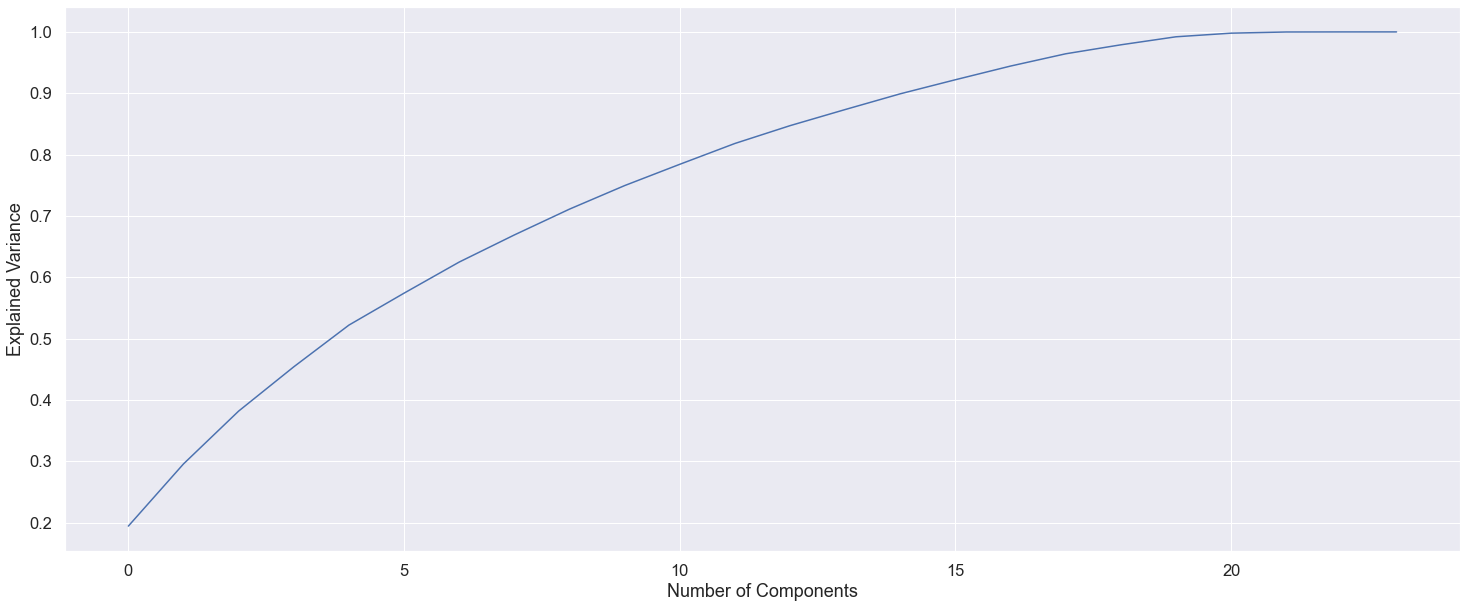

In [59]:
# study the amount of variance explained by each variable

pca_all = PCA(n_components=processed_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(processed_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1st and 2nd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1st to 3rd components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1st to 4th components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [60]:
# Get the numerical variance explained by the first two principal components

pca_2 = PCA(n_components=2, random_state=randomstate)
x_pca_2 = pca_2.fit_transform(x_sample)

print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

Explained variation per principal component: [0.19501982 0.10142041]


Text(0, 0.5, 'Second Component')

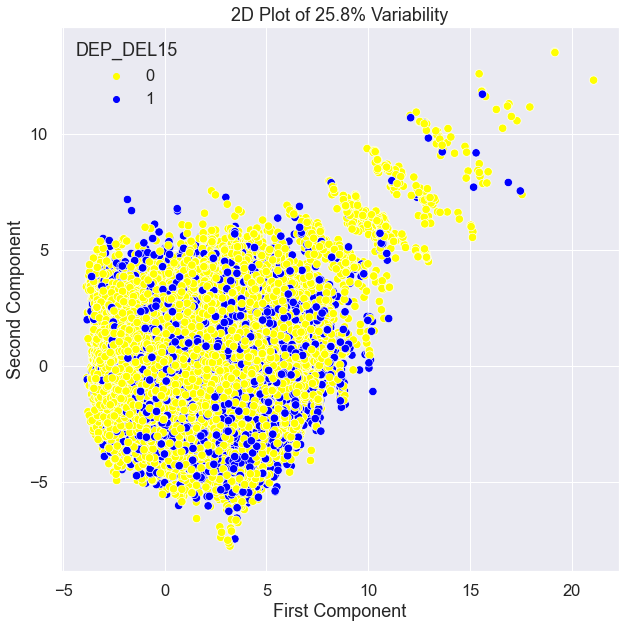

In [61]:
# 2D plot of the first two components

plt.figure(figsize=(10,10))
sns.scatterplot(x=x_pca_2[:,0], y=x_pca_2[:,1], s=70, hue=y_sample, palette=['yellow', 'blue'])
plt.title("2D Plot of 25.8% Variability")
plt.xlabel("First Component")
plt.ylabel("Second Component")

In [62]:
# Reducing the dataset into principal components that explain 95% of the variance

pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(x_sample)
x_pca_95_test = pca_95th.transform(x_rest)

print(x_pca_95.shape[1],"components, starting from all features")

18 components, starting from all features


In [63]:
# spot check the models using the 95% principal components

spot_check = spot_check_classifier(xgbc, x_pca_95, y_sample, "XGBoost_Weighted_PCA", x_pca_95_test, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, x_pca_95, y_sample, "CatBoost_Weighted_PCA", x_pca_95_test, y_rest, spot_check)
spot_check = spot_check_classifier(forest, x_pca_95, y_sample, "Balanced_Forest_PCA", x_pca_95_test, y_rest, spot_check)
spot_check = spot_check_classifier(log, x_pca_95, y_sample, "LogReg_Weighted_PCA", x_pca_95_test, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, x_pca_95, y_sample, "DecisionTree_PCA", x_pca_95_test, y_rest, spot_check)



Running XGBoost_Weighted_PCA Classification
CV 5 Accuracy Train Score: 65.0
CV 5 F1 Train Score: 40.03
CV 5 Auc Train Score: 68.24
CV 5 Precision Train Score: 30.04
CV 5 Recall Train Score: 59.95

Validation Accuracy ( 0.5 Thresh)):  0.650090450153372
Validation f1 Score ( 0.5 Thresh):  0.40368557443132735
Validation AUC Score ( 0.5 Thresh):  0.6341021813207184
Validation Precision Score ( 0.5 Thresh):  0.3021731375230394
Validation Recall Score ( 0.5 Thresh):  0.6079064621273287 

              precision    recall  f1-score   support

           0       0.87      0.66      0.75    276401
           1       0.30      0.61      0.40     66882

    accuracy                           0.65    343283
   macro avg       0.59      0.63      0.58    343283
weighted avg       0.76      0.65      0.68    343283

Elapsed Time: 75.73836922645569


Running CatBoost_Weighted_PCA Classification
CV 5 Accuracy Train Score: 64.13
CV 5 F1 Train Score: 40.72
CV 5 Auc Train Score: 69.16
CV 5 Precision Tr

In [64]:
# testing the principal components AFTER using permutation importance

pca_95th_perm = PCA(n_components=.95, random_state=randomstate)
x_pca_95_perm = pca_95th_perm.fit_transform(permutation_x_train)
x_pca_perm_test = pca_95th_perm.transform(permutation_x_test)

print(x_pca_95_perm.shape[1],"components, starting from permuted features")

15 components, starting from permuted features


In [65]:
# spot check the PCA with permutation importance

spot_check = spot_check_classifier(xgbc, x_pca_95_perm, y_sample, "XGBoost_Weighted_PCA_Perm", x_pca_perm_test, y_rest, spot_check)
spot_check = spot_check_classifier(catboost, x_pca_95_perm, y_sample, "CatBoost_Weighted_PCA_Perm", x_pca_perm_test, y_rest, spot_check)
spot_check = spot_check_classifier(forest, x_pca_95_perm, y_sample, "Balanced_Forest_PCA_Perm", x_pca_perm_test, y_rest, spot_check)
spot_check = spot_check_classifier(log, x_pca_95_perm, y_sample, "LogReg_Weighted_PCA_Perm", x_pca_perm_test, y_rest, spot_check)
spot_check = spot_check_classifier(decision_tree, x_pca_95_perm, y_sample, "DecisionTree_PCA_Perm", x_pca_perm_test, y_rest, spot_check)



Running XGBoost_Weighted_PCA_Perm Classification
CV 5 Accuracy Train Score: 64.41
CV 5 F1 Train Score: 39.61
CV 5 Auc Train Score: 67.73
CV 5 Precision Train Score: 29.59
CV 5 Recall Train Score: 59.92

Validation Accuracy ( 0.5 Thresh)):  0.6444391362228832
Validation f1 Score ( 0.5 Thresh):  0.4009305704161063
Validation AUC Score ( 0.5 Thresh):  0.6316468283491804
Validation Precision Score ( 0.5 Thresh):  0.29842763619359364
Validation Recall Score ( 0.5 Thresh):  0.6106874794414042 

              precision    recall  f1-score   support

           0       0.87      0.65      0.75    276401
           1       0.30      0.61      0.40     66882

    accuracy                           0.64    343283
   macro avg       0.59      0.63      0.57    343283
weighted avg       0.76      0.64      0.68    343283

Elapsed Time: 46.90365505218506


Running CatBoost_Weighted_PCA_Perm Classification
CV 5 Accuracy Train Score: 63.87
CV 5 F1 Train Score: 40.36
CV 5 Auc Train Score: 68.7
CV 5 P

In [66]:
del [pca_all, x_pca, pca_2, x_pca_2, pca_95th, x_pca_95, x_pca_95_test, pca_95th_perm, x_pca_95_perm, x_pca_perm_test]

## Evaluate Spot Checks

Here's where we see what, if anything, worked and what models we try on our holdout sets.

In [67]:
chart = pd.DataFrame(spot_check)
chart.sort_values('f1', ascending=False).reset_index(drop=True)

,Model,f1,accuracy,auc,precision,recall,time
0,XGBoost_Weighted w/Permutation Importance,0.425428,0.672777,0.653449,0.323325,0.621782,37.758332
1,XGBoost_Weighted,0.425337,0.672766,0.653363,0.323276,0.621572,39.950821
2,XGBoost_Weighted_TomekLinks,0.423573,0.646236,0.654155,0.310292,0.667130,37.299932
3,CatBoost_Weighted,0.422210,0.658623,0.651635,0.314968,0.640187,69.798494
4,CatBoost_Weighted_w/Permutation Importance,0.421996,0.658570,0.651427,0.314841,0.639724,68.816590
5,CatBoost_Weighted_TomekLinks,0.421749,0.654821,0.651513,0.313049,0.646093,65.988504
6,CatBoost_Weighted_RUS,0.421628,0.655145,0.651363,0.313133,0.645166,53.252926
7,Balanced_Forest_w/Permutation Importance,0.420957,0.645051,0.651560,0.308545,0.662226,33.948375
8,Balanced Random Forest,0.419917,0.643452,0.650624,0.307396,0.662376,33.589550
9,Balanced_Forest_TomekLinks,0.418907,0.638730,0.649964,0.305050,0.668371,36.063286


## Tuned Base Models

We tuned as our Base-Models:

* XGBoost
* Balanced Random Forest
* CatBoost Weighted
* Logistic Regression Weighted (Other forms of LR were SLIGHTLY better but more computationally expensive and involve different data; we need all the same data for our stacked classifier)
* Decision Tree Regressor

We'll use permutation importance for our feature selection with all of these models, as most preferred it. Then, we will stack the models. None perform very well individually, so we will hope for a better overall result when stacked. We will use a second logistic regressor as our meta-model.

Hyperparameter tuning is located in the APPENDIX


Now we will fit all of our tuned base models to the Training data set

In [24]:
permutation_train = processed_train[important_features]
permutation_val = processed_val[important_features]

# We have a lot of large variables taking memory at this point, and we need to free up as much as possible for our next processes


del [processed_train, processed_val, 
     x_break, x_discard, y_break, y_discard, x_sample, x_rest, y_sample, y_rest,
    ]

gc.collect()

In [69]:
cats_tuned = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, 
                depth = 7,
              iterations = 1000,
              learning_rate = .01, 
              l2_leaf_reg = 50,
              border_count = 255,
            random_strength = 0,
            bagging_temperature = 1)



Running CatBoost_Optimized Classification
CV 5 Accuracy Train Score: 64.89
CV 5 F1 Train Score: 41.72
CV 5 Auc Train Score: 70.51
CV 5 Precision Train Score: 30.83
CV 5 Recall Train Score: 64.49

Validation Accuracy ( 0.5 Thresh)):  0.6207554969390366
Validation f1 Score ( 0.5 Thresh):  0.29297443880881835
Validation AUC Score ( 0.5 Thresh):  0.5968727010627541
Validation Precision Score ( 0.5 Thresh):  0.197912888267238
Validation Recall Score ( 0.5 Thresh):  0.5637594868021022 

              precision    recall  f1-score   support

           0       0.90      0.63      0.74    830690
           1       0.20      0.56      0.29    134529

    accuracy                           0.62    965219
   macro avg       0.55      0.60      0.52    965219
weighted avg       0.80      0.62      0.68    965219


Confusion Matrix for Test Set


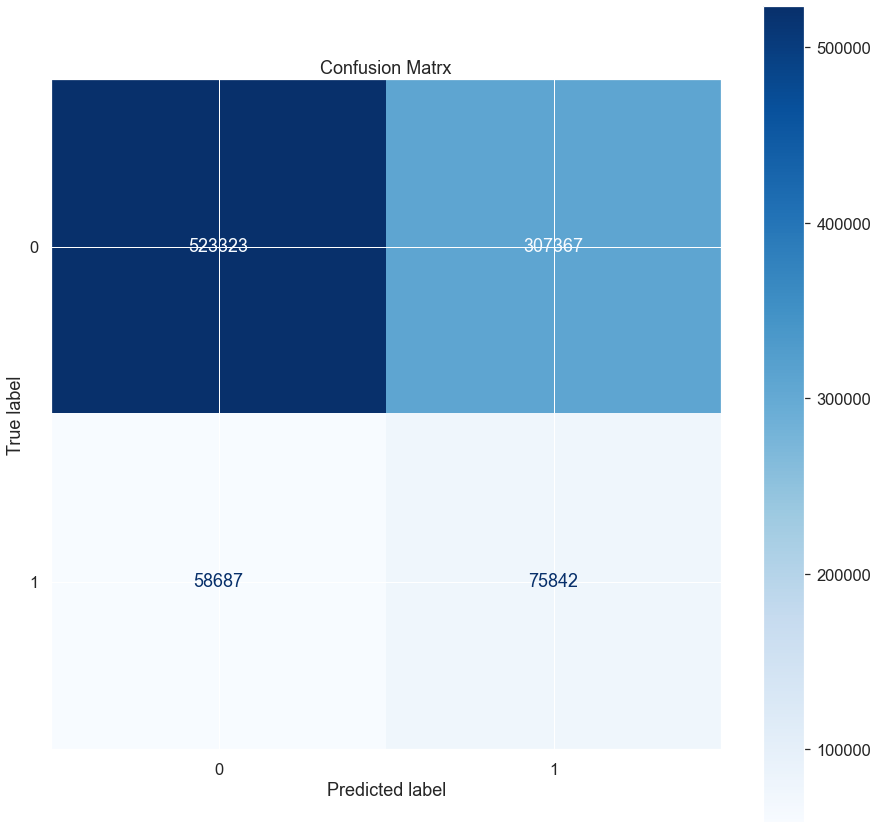

Best Threshold=0.503416, F-Score=0.293


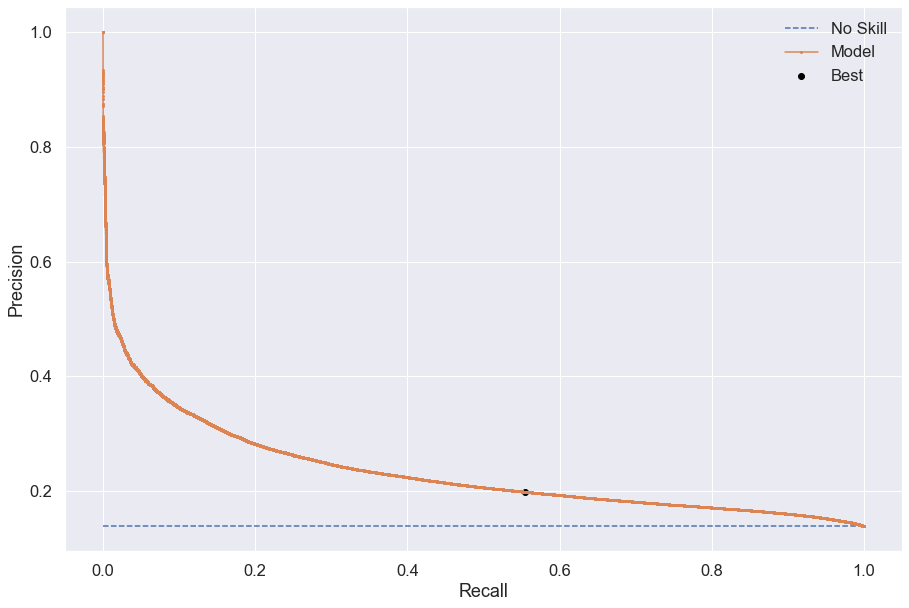

Elapsed Time: 2114.9216599464417


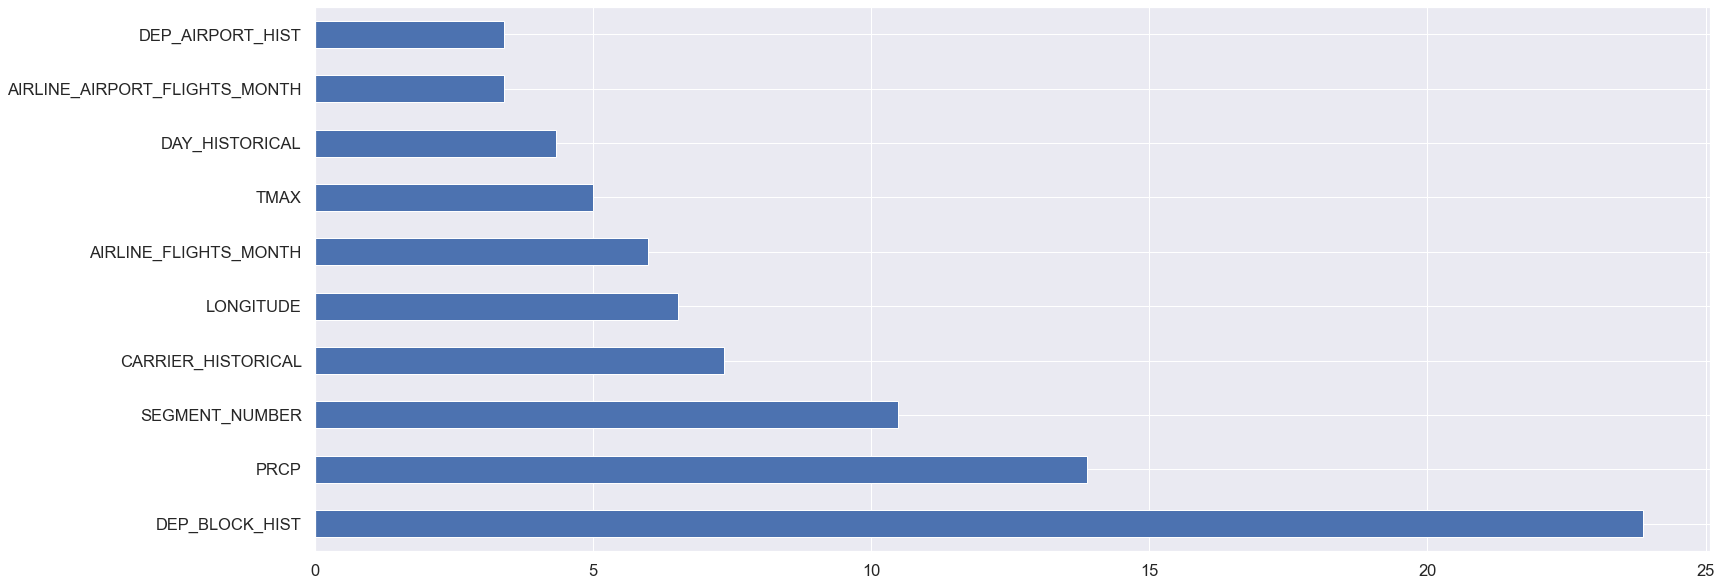

In [70]:
cats_tuned = make_classifier(cats_tuned, permutation_train, permutation_val, y_train, y_val, "CatBoost_Optimized", important_features, models)

In [71]:
bal_forest = BalancedRandomForestClassifier(random_state=randomstate, criterion = 'gini', max_depth=None,
                                           max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 10,
                                           n_estimators = 1000)



Running RandomForest_Balanced Classification
CV 5 Accuracy Train Score: nan
CV 5 F1 Train Score: nan
CV 5 Auc Train Score: nan
CV 5 Precision Train Score: nan
CV 5 Recall Train Score: nan

Validation Accuracy ( 0.5 Thresh)):  0.6452038345701856
Validation f1 Score ( 0.5 Thresh):  0.29994439720023547
Validation AUC Score ( 0.5 Thresh):  0.6033581766954952
Validation Precision Score ( 0.5 Thresh):  0.2068601880700963
Validation Recall Score ( 0.5 Thresh):  0.5453396665402999 

              precision    recall  f1-score   support

           0       0.90      0.66      0.76    830690
           1       0.21      0.55      0.30    134529

    accuracy                           0.65    965219
   macro avg       0.55      0.60      0.53    965219
weighted avg       0.80      0.65      0.70    965219


Confusion Matrix for Test Set


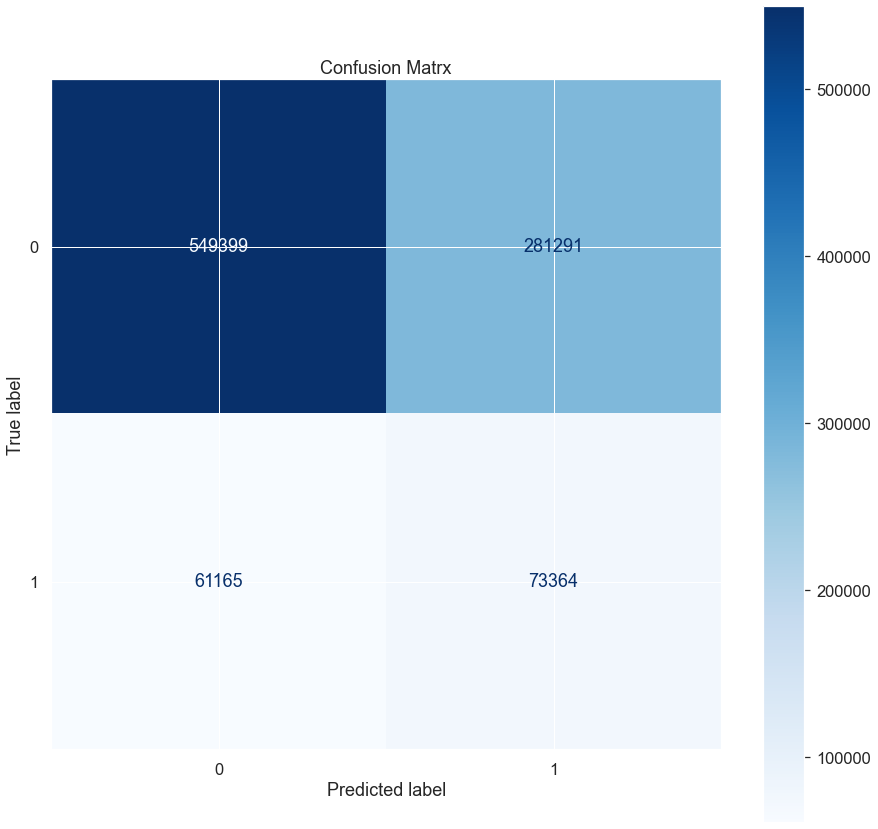

Best Threshold=0.929889, F-Score=nan


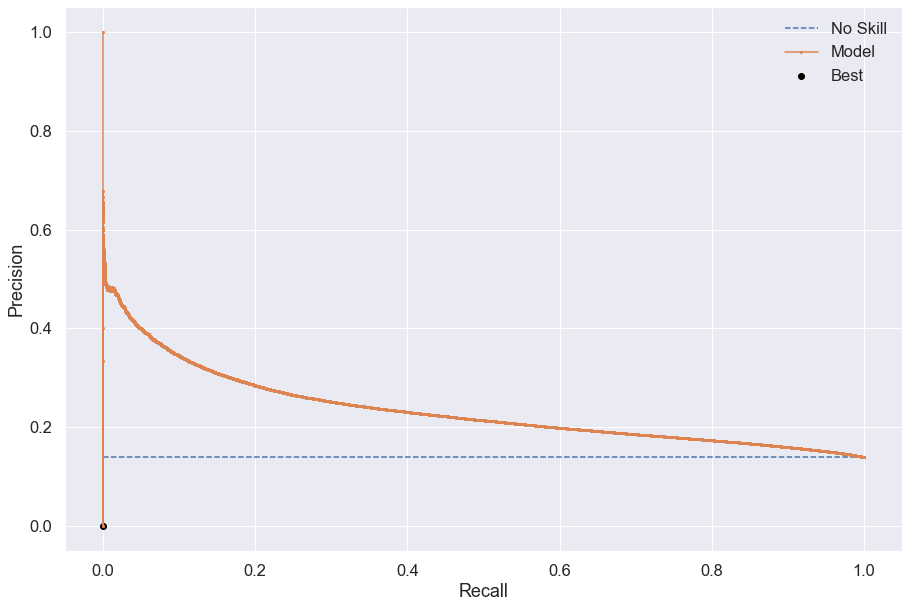

Elapsed Time: 32951.31784462929


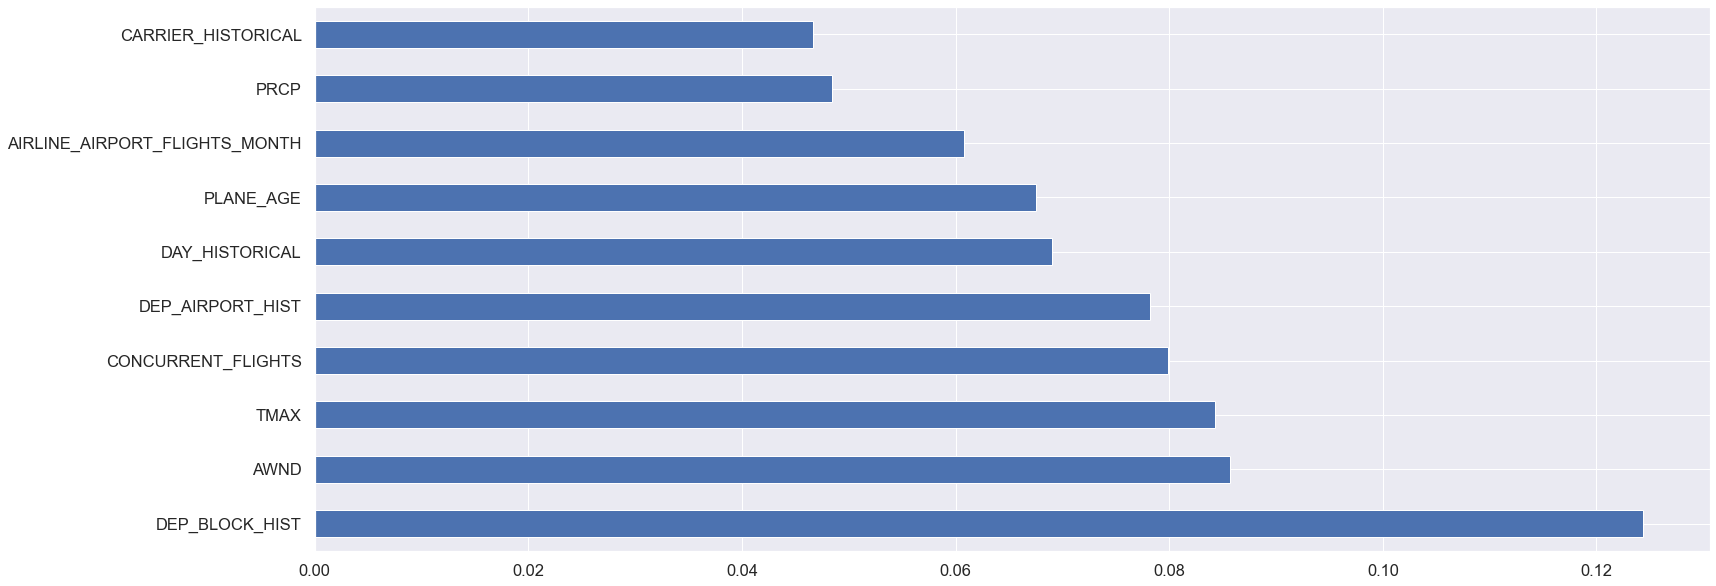

In [72]:
bal_forest = make_classifier(bal_forest, permutation_train, permutation_val, y_train, y_val, "RandomForest_Balanced", important_features, models)

In [73]:
log_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=100, n_jobs=-1,
                                 solver='liblinear', penalty='l2', l1_ratio=1)



Running LogReg_Weighted Classification
CV 5 Accuracy Train Score: 59.03
CV 5 F1 Train Score: 38.98
CV 5 Auc Train Score: 66.81
CV 5 Precision Train Score: 27.46
CV 5 Recall Train Score: 67.17

Validation Accuracy ( 0.5 Thresh)):  0.5807334915703068
Validation f1 Score ( 0.5 Thresh):  0.27361430212521537
Validation AUC Score ( 0.5 Thresh):  0.5747920968208375
Validation Precision Score ( 0.5 Thresh):  0.18035878662820554
Validation Recall Score ( 0.5 Thresh):  0.5665544232098655 

              precision    recall  f1-score   support

           0       0.89      0.58      0.71    830690
           1       0.18      0.57      0.27    134529

    accuracy                           0.58    965219
   macro avg       0.54      0.57      0.49    965219
weighted avg       0.79      0.58      0.65    965219


Confusion Matrix for Test Set


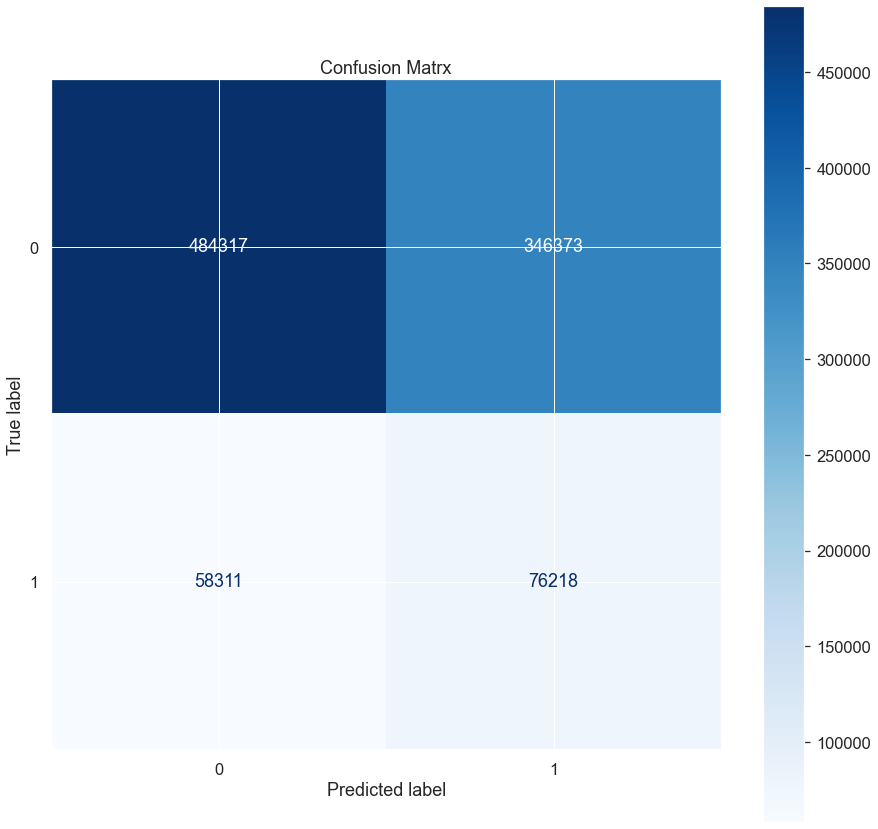

Best Threshold=0.468853, F-Score=0.276


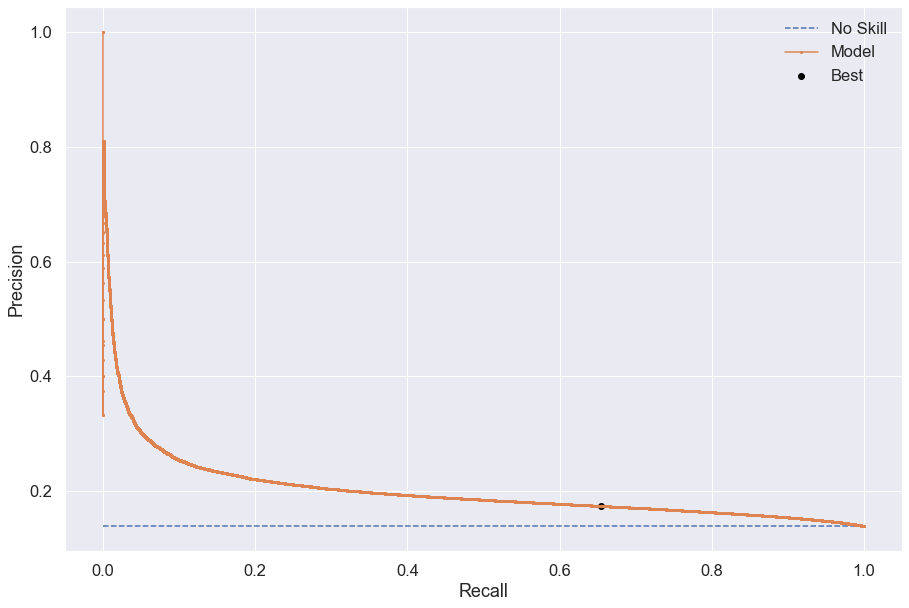

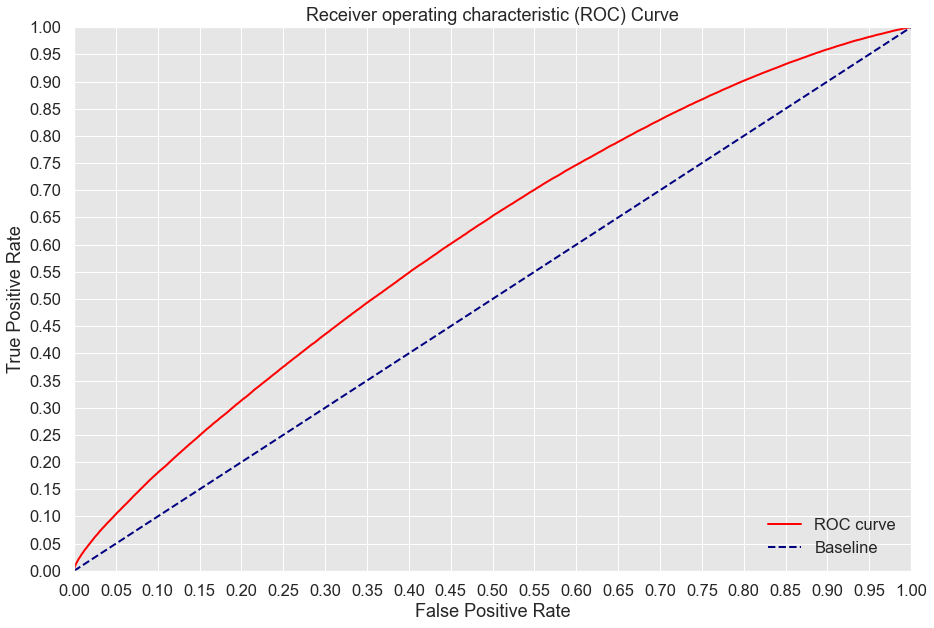

Elapsed Time: 96.56090331077576


In [74]:
log_weighted = make_classifier(log_weighted, permutation_train, permutation_val, y_train, y_val, "LogReg_Weighted", important_features, models)

In [75]:
xgbc_tuned = XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbosity=1, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = 10,
                        max_depth = 10,
                        subsample = .3,
                        min_child_weight = 10,
                        n_estimators = 1000,
                        colsample_bytree = .7,
                        alpha=1,
                        reg_lambda=1,
                        max_delta_step=3)



Running XGBoost_Optimized Classification
CV 5 Accuracy Train Score: 67.95
CV 5 F1 Train Score: 44.28
CV 5 Auc Train Score: 73.43
CV 5 Precision Train Score: 33.48
CV 5 Recall Train Score: 65.35

Validation Accuracy ( 0.5 Thresh)):  0.6690367678216032
Validation f1 Score ( 0.5 Thresh):  0.3026983842872921
Validation AUC Score ( 0.5 Thresh):  0.6046613526683675
Validation Precision Score ( 0.5 Thresh):  0.21426960076885757
Validation Recall Score ( 0.5 Thresh):  0.5154056002794937 

              precision    recall  f1-score   support

           0       0.90      0.69      0.78    830690
           1       0.21      0.52      0.30    134529

    accuracy                           0.67    965219
   macro avg       0.56      0.60      0.54    965219
weighted avg       0.80      0.67      0.72    965219


Confusion Matrix for Test Set


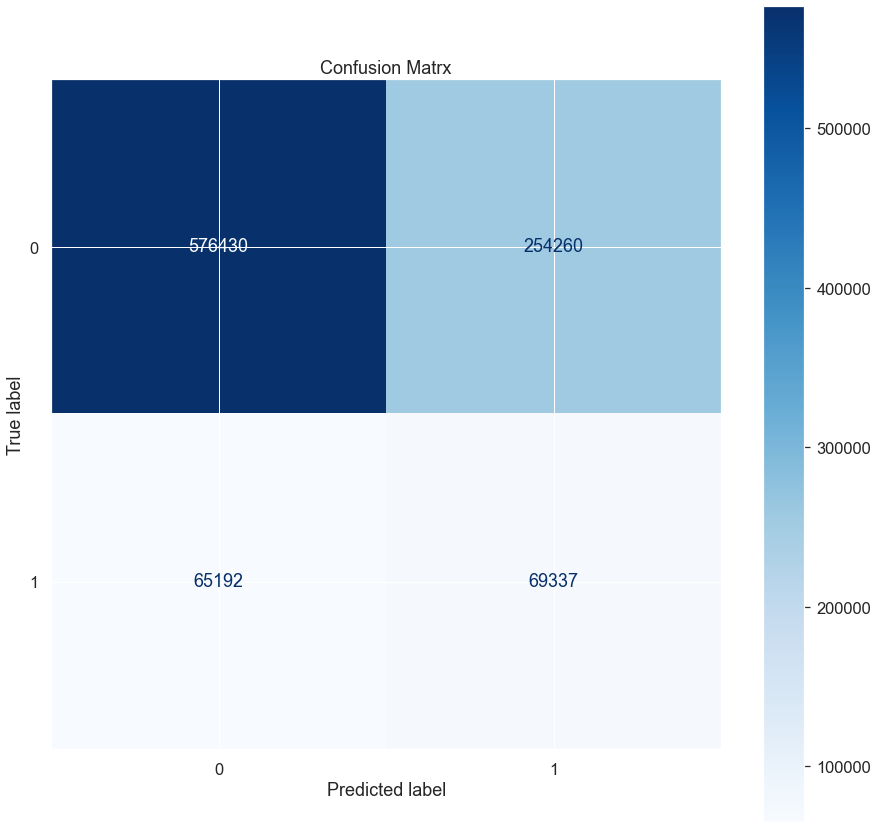

Best Threshold=0.501582, F-Score=0.303


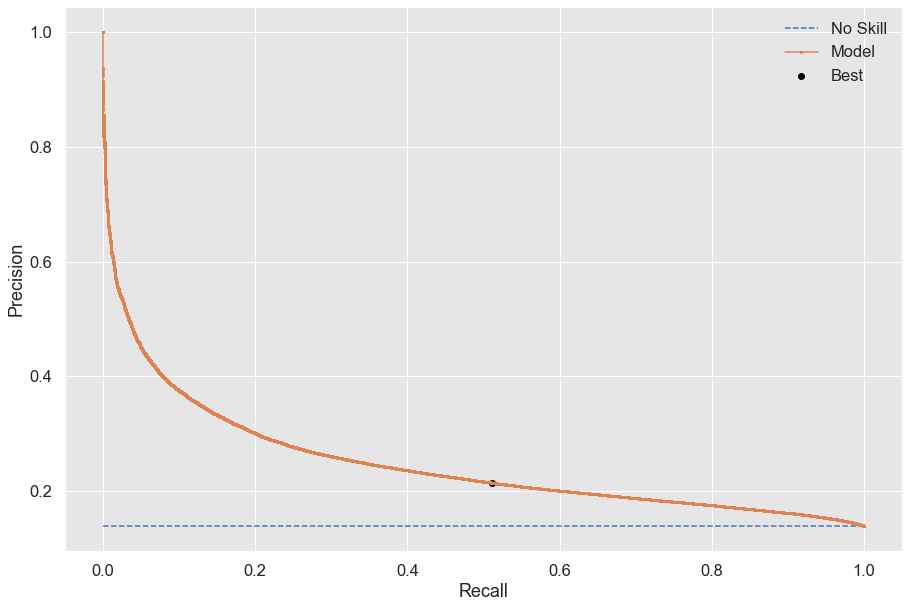

Elapsed Time: 1858.9293940067291


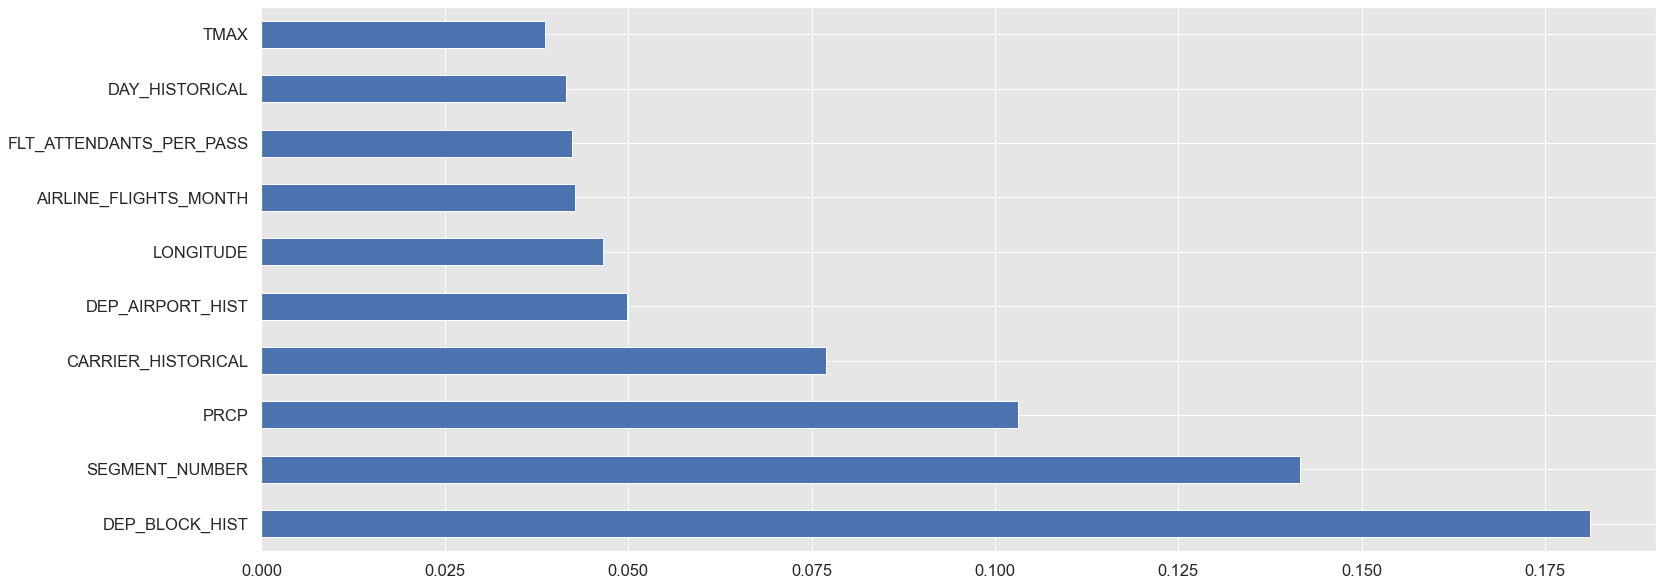

In [76]:
xgbc_tuned = make_classifier(xgbc_tuned, permutation_train, permutation_val, y_train, y_val, "XGBoost_Optimized", important_features, models)

In [86]:
decision_tuned = DecisionTreeClassifier(class_weight='balanced', random_state=randomstate, max_depth=8, criterion='gini',
                                       max_features='log2', min_samples_split=2, min_samples_leaf=1)



Running DecisionTree Classification
CV 5 Accuracy Train Score: 63.09
CV 5 F1 Train Score: 39.31
CV 5 Auc Train Score: 67.22
CV 5 Precision Train Score: 28.93
CV 5 Recall Train Score: 61.36

Validation Accuracy ( 0.5 Thresh)):  0.5729435495985885
Validation f1 Score ( 0.5 Thresh):  0.2828969915642718
Validation AUC Score ( 0.5 Thresh):  0.5861173623913833
Validation Precision Score ( 0.5 Thresh):  0.18466776291881679
Validation Recall Score ( 0.5 Thresh):  0.6043826981543013 

              precision    recall  f1-score   support

           0       0.90      0.57      0.70    830690
           1       0.18      0.60      0.28    134529

    accuracy                           0.57    965219
   macro avg       0.54      0.59      0.49    965219
weighted avg       0.80      0.57      0.64    965219


Confusion Matrix for Test Set


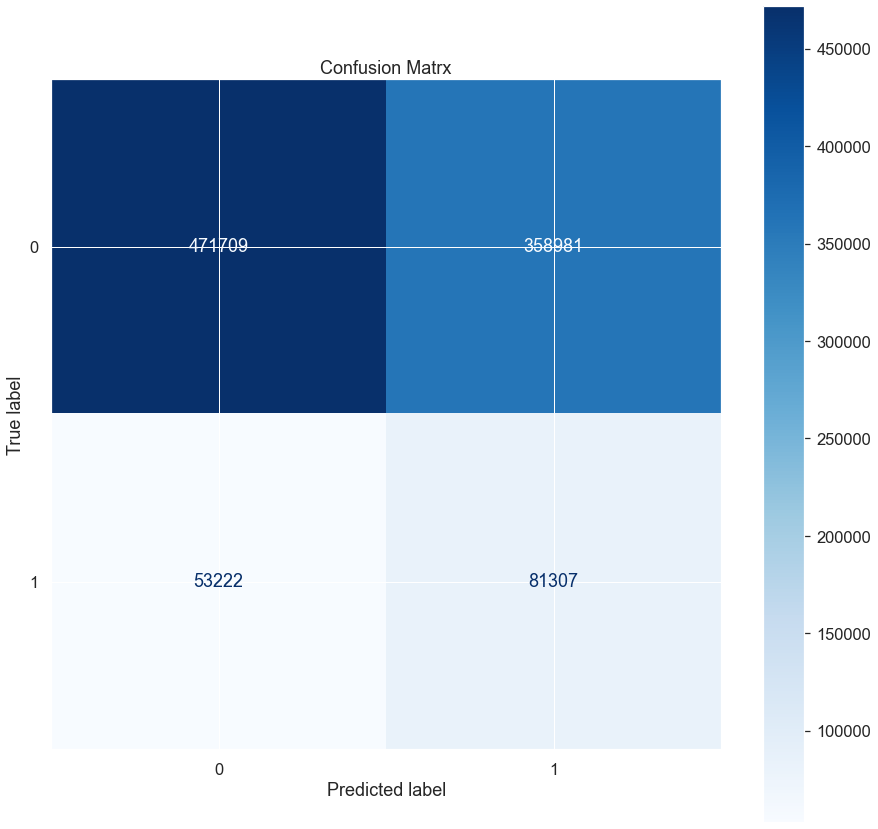

Best Threshold=0.502953, F-Score=0.283


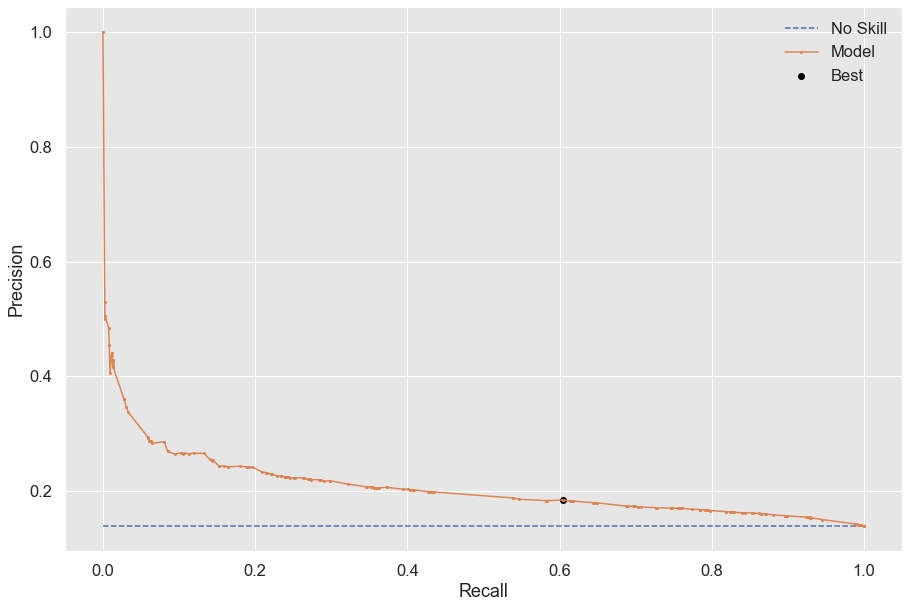

Elapsed Time: 125.7598602771759


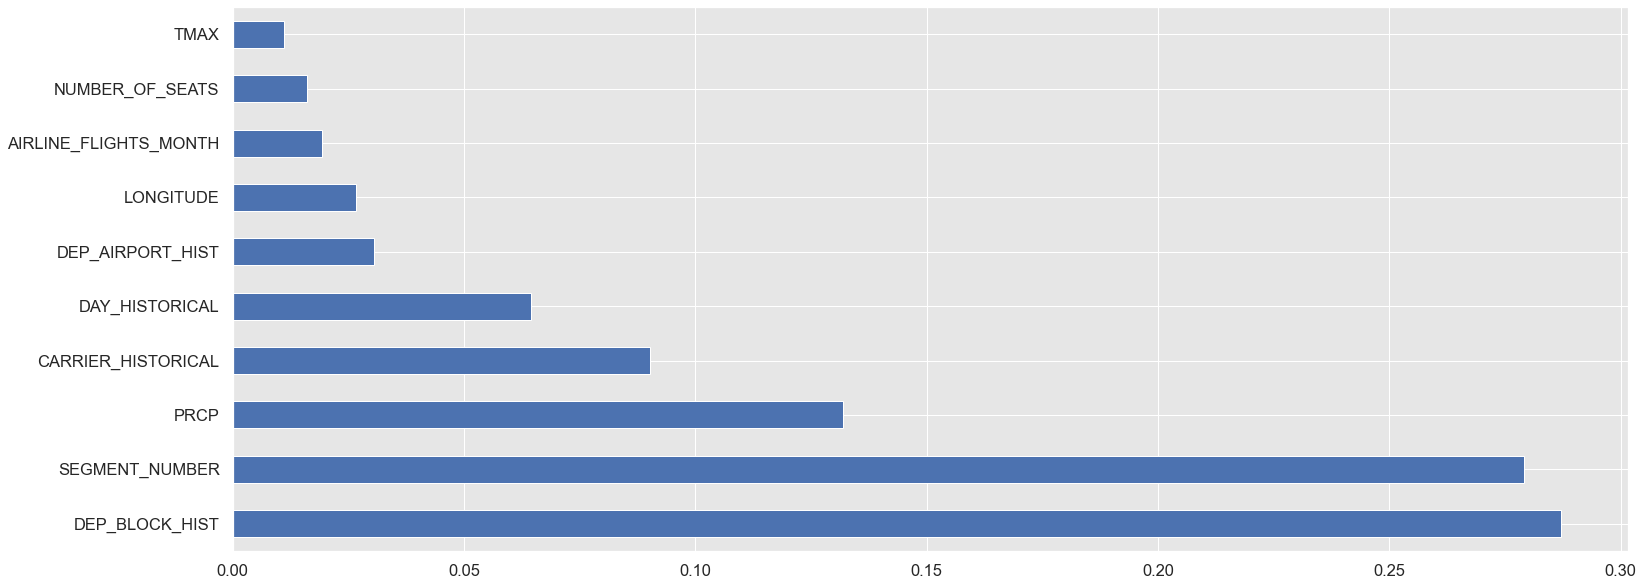

In [87]:
decision_tuned = make_classifier(decision_tuned, permutation_train, permutation_val, y_train, y_val, "DecisionTree", important_features, models)

In [88]:
chart = pd.DataFrame(models)
chart.sort_values('f1', ascending=False)

,Model,f1,accuracy,auc,precision,recall,time
3,XGBoost_Optimized,0.302698,0.669037,0.604661,0.214270,0.515406,1858.929394
1,RandomForest_Balanced,0.299944,0.645204,0.603358,0.206860,0.545340,32951.317845
0,CatBoost_Optimized,0.292974,0.620755,0.596873,0.197913,0.563759,2114.921660
4,DecisionTree,0.282897,0.572944,0.586117,0.184668,0.604383,125.759860
2,LogReg_Weighted,0.273614,0.580733,0.574792,0.180359,0.566554,96.560903


Individual scores on these models were basically disastrous. We have at best a 60

## Tuned Stacked Model

To implement our stacked model, we will be using out-of-sample predictions to create our level 1 predictions. This means that we are splitting our data into 5 folds and, for each model, creating predictions for each of those folds using the other 4 folds. In this way we are creating cross-validated predictions with no internal leakage.

The code blocks for model stacking are heavily derived from the article at https://machinelearningmastery.com/out-of-fold-predictions-in-machine-learning/  and do the following:

* Divide the data into 5 splits
* For each split, train on the large group and predict on the left-out fold
* Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order
* Create a meta dataset with each column comprised of the predictions from level 1, as well as a column with the original data
* Fit the final base models on the base dataset
* Fit the meta model on the meta dataset
* Predict on new data using the base models and meta model

### Get 1st Level Predictions

In [25]:
cats_final = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, 
                depth = 7,
              iterations = 1000,
              learning_rate = .01, 
              l2_leaf_reg = 50,
              border_count = 255,
            random_strength = 0,
            bagging_temperature = 1)

In [26]:
forest_final = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1, criterion = 'gini', max_depth=None,
                                           max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 10,
                                           n_estimators = 1000)

In [27]:
logreg_final = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=100, n_jobs=-1,
                                 solver='liblinear', penalty='l2', l1_ratio=1)

In [28]:
xgbc_final = XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbosity=1, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = 10,
                        max_depth = 10,
                        subsample = .3,
                        min_child_weight = 10,
                        n_estimators = 1000,
                        colsample_bytree = .7,
                        alpha=1,
                        reg_lambda=1,
                        max_delta_step=3)

In [29]:
dectree_final = DecisionTreeClassifier(class_weight='balanced', random_state=randomstate, max_depth=8, criterion='gini',
                                       max_features='log2', min_samples_split=2, min_samples_leaf=1)

In [30]:
# collect out of sample predictions

# Divide the data into 5 splits
# For each split, train on the large group and predict on the left-out fold
# Add those predictions to larger lists of data, thereby keeping all of the data in the exact same order

data_x, data_y, cats_yhat, forest_yhat, logreg_yhat, xgbc_yhat, dectree_yhat = [], [], [], [], [], [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train_ix, test_ix in kfold.split(permutation_train, y_train):
    
    print("\nStarting a new fold\n")
    
    print("Creating splits")
    # get data
    train_X, test_X = permutation_train.iloc[train_ix], permutation_train.iloc[test_ix]
    train_y, test_y = y_train.iloc[train_ix], y_train.iloc[test_ix]
    test_X = np.array(test_X)
    train_X = np.array(train_X)
    
    print("Adding x and y to lists")
    # add the used data to lists
    data_x.extend(test_X)
    data_y.extend(test_y)
    
    # fit and make predictions with Catboost
    print("Running CatBoost on this fold")
    cats_final.fit(train_X, train_y)
    yhat1 = cats_final.predict_proba(test_X)[:, 0]   
    cats_yhat.extend(yhat1) # add predictions to list for that classifier
    
    # fit and make predictions with Random Forest
    print("Running Random Forest on this fold")
    forest_final.fit(train_X, train_y)
    yhat2 = forest_final.predict_proba(test_X)[:, 0]   
    forest_yhat.extend(yhat2) # add predictions to list for that classifier
    
    # fit and make predictions with Logistic Regression
    print("Running Logistic Regression on this fold")
    logreg_final.fit(train_X, train_y)
    yhat3 = logreg_final.predict_proba(test_X)[:, 0]   
    logreg_yhat.extend(yhat3) # add predictions to list for that classifier    
    
    # fit and make predictions with Logistic Regression
    print("Running Decision Tree on this fold")
    dectree_final.fit(train_X, train_y)
    yhat4 = dectree_final.predict_proba(test_X)[:, 0]   
    dectree_yhat.extend(yhat4) # add predictions to list for that classifier
       
    # fit and make predictions with XGBC
    print("Running XGBoost on this fold")
    xgbc_final.fit(train_X, train_y)
    yhat5 = xgbc_final.predict_proba(test_X)[:, 0]   
    xgbc_yhat.extend(yhat5) # add predictions to list for that classifier 
    
    


Starting a new fold

Creating splits
Adding x and y to lists
Running CatBoost on this fold
Running Random Forest on this fold
Running Logistic Regression on this fold
Running Decision Tree on this fold
Running XGBoost on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running CatBoost on this fold
Running Random Forest on this fold
Running Logistic Regression on this fold
Running Decision Tree on this fold
Running XGBoost on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running CatBoost on this fold
Running Random Forest on this fold
Running Logistic Regression on this fold
Running Decision Tree on this fold
Running XGBoost on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running CatBoost on this fold
Running Random Forest on this fold
Running Logistic Regression on this fold
Running Decision Tree on this fold
Running XGBoost on this fold

Starting a new fold

Creating splits
Adding x and y to lists
Running Ca

In [31]:
pd.DataFrame(data_x).to_pickle('pkl/data_x.pkl')
pd.DataFrame(data_y).to_pickle('pkl/data_y.pkl')
pd.DataFrame(cats_yhat).to_pickle('pkl/cats_yhat.pkl')
pd.DataFrame(forest_yhat).to_pickle('pkl/forest_yhat.pkl')
pd.DataFrame(logreg_yhat).to_pickle('pkl/logreg_yhat.pkl')
pd.DataFrame(dectree_yhat).to_pickle('pkl/dectree_yhat.pkl')
pd.DataFrame(xgbc_yhat).to_pickle('pkl/xgbc_yhat.pkl')

In [32]:
# Fit the final base models on the base Train datasets

print("Fitting Catboost")
cats_final.fit(permutation_train, y_train)
print("Fitting Random Forest")
forest_final.fit(permutation_train, y_train)
print("Fitting Logistic Regression")
logreg_final.fit(permutation_train, y_train)
print("Fitting XGBoost")
xgbc_final.fit(permutation_train, y_train)
print("Fitting Decision Tree")
dectree_final.fit(permutation_train, y_train)

Fitting Catboost
Fitting Random Forest
Fitting Logistic Regression
Fitting XGBoost
Fitting Decision Tree


DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       max_features='log2', random_state=42)

### Create meta data set

In [33]:
# construct Training meta dataset
meta_X_train = create_meta_dataset(data_x, cats_yhat, forest_yhat, logreg_yhat, xgbc_yhat, dectree_yhat)

In [34]:
# instantiate the meta classifier
meta_model = XGBClassifier(scale_pos_weight=scale_weight, random_state=randomstate, verbosity=0, n_jobs=-1)

# fit the meta model to the Train meta dataset
# There is no data leakage in the meta dataset since we did all of our predictions out-of-sample
meta_model.fit(meta_X_train, data_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.132657741255785,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=0)

### Predict on Validation set

In [39]:
# Send all of the fitted models and the Validation data set to get a Validation meta set
meta_X_val = stack_prediction(cats_final, forest_final, logreg_final, xgbc_final, dectree_final, meta_model, permutation_val, y_val)

# Get our probabilities and predictions for the meta model on our Validation meta data set
probabilities, predictions, models = validation_scoring(meta_model, meta_X_val, y_val, "Stacked Model", models)


Validation Accuracy ( 0.5 Thresh)):  0.6722640146951107
Validation f1 Score ( 0.5 Thresh):  0.30199711828915515
Validation AUC Score ( 0.5 Thresh):  0.6037205556063528
Validation Precision Score ( 0.5 Thresh):  0.21474296616605057
Validation Recall Score ( 0.5 Thresh):  0.5086858595544456 

              precision    recall  f1-score   support

           0       0.90      0.70      0.79    830690
           1       0.21      0.51      0.30    134529

    accuracy                           0.67    965219
   macro avg       0.56      0.60      0.54    965219
weighted avg       0.80      0.67      0.72    965219



Best Threshold=0.472100, F-Score=0.302


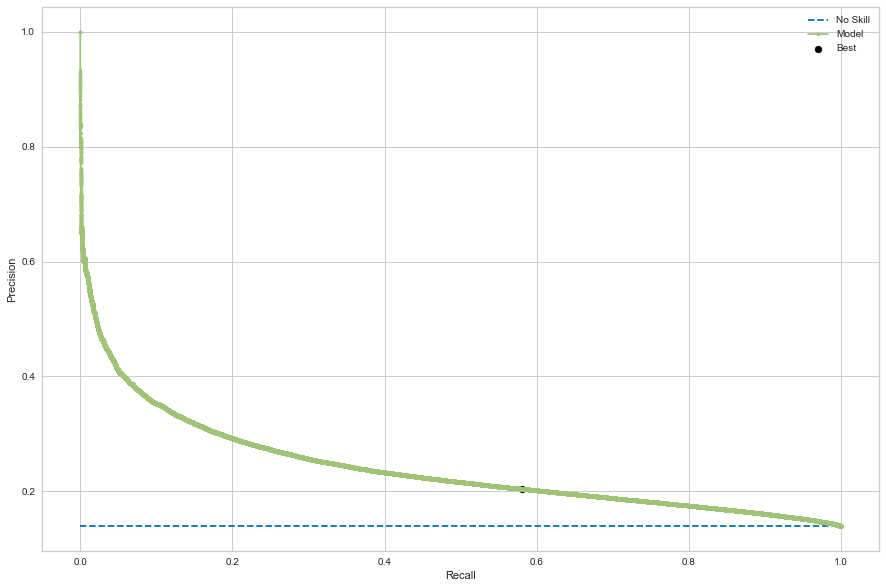

In [41]:
# Plot the pr_roc and find the optimal threshold 

plot_roc(y_val, probabilities)

In [42]:
# Redo our predictions using the optimal threshold

probabilities, predictions, models = validation_scoring(meta_model, meta_X_val, y_val, "Stacked Model", models, .47)


Validation Accuracy ( 0.47 Thresh)):  0.6226897729945224
Validation f1 Score ( 0.47 Thresh):  0.302260931539813
Validation AUC Score ( 0.47 Thresh):  0.6074684553619902
Validation Precision Score ( 0.47 Thresh):  0.2036089658875031
Validation Recall Score ( 0.47 Thresh):  0.5863642783340395 

              precision    recall  f1-score   support

           0       0.90      0.63      0.74    830690
           1       0.20      0.59      0.30    134529

    accuracy                           0.62    965219
   macro avg       0.55      0.61      0.52    965219
weighted avg       0.81      0.62      0.68    965219



### New Data

The moment of truth has arrived. We load in entirely new data and run our model against it.

In [43]:
# Load ALL Data
test = pd.read_pickle("data/pkl/test.pkl")

# Make x-test and y-test
x_test = test.drop('DEP_DEL15', axis=1)
y_test = test['DEP_DEL15']

# process test data
x_test.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH',
                     'AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

processed_test = pipeline_transform_preprocessor(x_test, pipe)

processed_test_perm = processed_test[important_features]

Transforming test data


In [44]:
# Send all of the fitted models and the Validation data set to get a Validation meta set
meta_X_test = stack_prediction(cats_final, forest_final, logreg_final, xgbc_final, dectree_final, meta_model, processed_test_perm, y_test)

# Get our probabilities and predictions for the meta model on our Validation meta data set
probabilities, predictions, models = validation_scoring(meta_model, meta_X_test, y_test, "New Data", models)


Validation Accuracy ( 0.5 Thresh)):  0.6722640146951107
Validation f1 Score ( 0.5 Thresh):  0.30199711828915515
Validation AUC Score ( 0.5 Thresh):  0.6037205556063528
Validation Precision Score ( 0.5 Thresh):  0.21474296616605057
Validation Recall Score ( 0.5 Thresh):  0.5086858595544456 

              precision    recall  f1-score   support

           0       0.90      0.70      0.79    830690
           1       0.21      0.51      0.30    134529

    accuracy                           0.67    965219
   macro avg       0.56      0.60      0.54    965219
weighted avg       0.80      0.67      0.72    965219




Confusion Matrix for Test Set


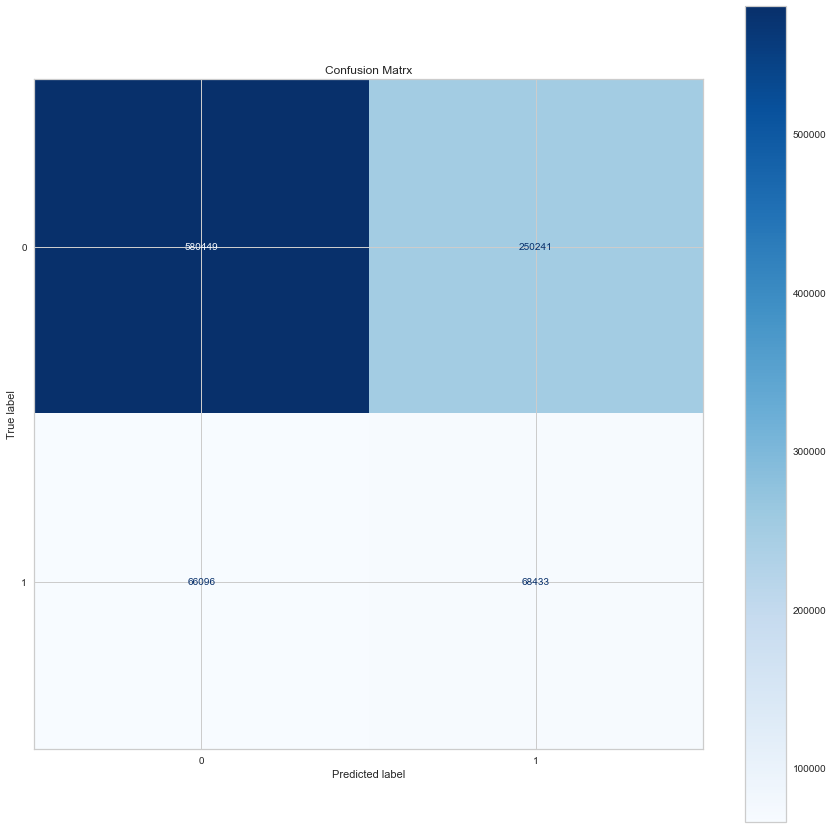

In [52]:
# Visualize Confusion Matrix
print("\nConfusion Matrix for Test Set")
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Confusion Matrx')
plot_confusion_matrix(meta_model, meta_X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.show()

Best Threshold=0.472100, F-Score=0.302


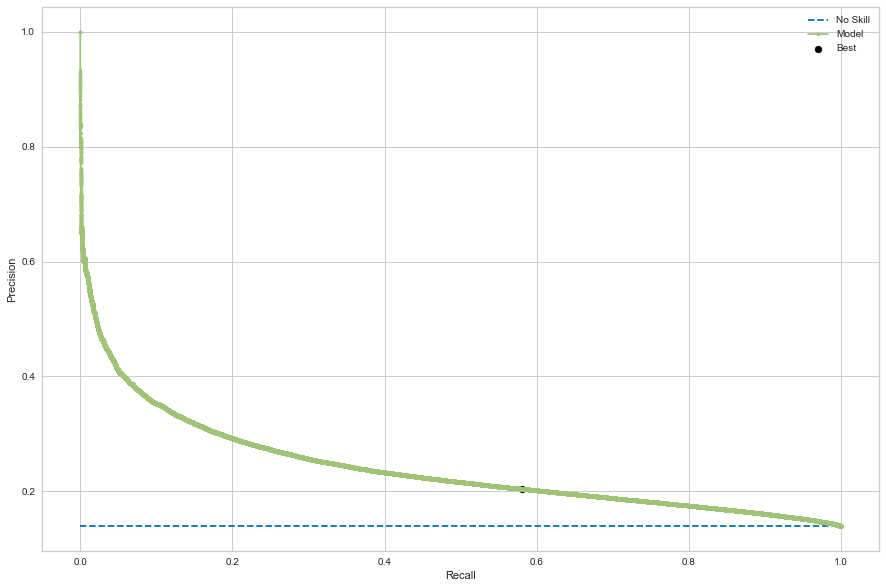

In [48]:
plot_roc(y_test, probabilities)

In [49]:
probabilities, predictions, models = validation_scoring(meta_model, meta_X_test, y_test, "New Data", models, .47)


Validation Accuracy ( 0.47 Thresh)):  0.6226897729945224
Validation f1 Score ( 0.47 Thresh):  0.302260931539813
Validation AUC Score ( 0.47 Thresh):  0.6074684553619902
Validation Precision Score ( 0.47 Thresh):  0.2036089658875031
Validation Recall Score ( 0.47 Thresh):  0.5863642783340395 

              precision    recall  f1-score   support

           0       0.90      0.63      0.74    830690
           1       0.20      0.59      0.30    134529

    accuracy                           0.62    965219
   macro avg       0.55      0.61      0.52    965219
weighted avg       0.81      0.62      0.68    965219



# Model Evaluation

We score our model on F1 score rather than Accuracy. Accuracy is very easy to reach on this data - the model simply predicts very few delays when tuning and scoring on Accuracy. We would use accuracy if all classes are equally important. It's possible that the cost of a false negative is low in this instance, but the entire purpose of the model is to understand and predict a delay, so we will consider the cost of false negatives to be high.

Since want to minimize the number of False Negatives, so we use F1-Score instead, which is the harmonic mean of precision (reduce false positives where a delay was predicted and was not) and recall (reduce false negatives where a delay was not predicted and was delayed). This overall gives us a better measure of the incorrect classifications.

F1 is also considered a better metric when the set is highly imbalanced, for the simple reason that if based on Accuracy, the model may simply always predict for the majority class. In our situation, with a 80/20 imbalance, the model could easily achieve 80% accuracy by simply always prediction that a flight will not be delayed. This is not a useful prediction for us.

# APPENDIX

## Hyperparameter Tuning

We tune our hyperparameters still using our smaller subset. We're using HalvingGridSearchVC which uses cross validation and an innovative iterative search method to quickly converge on the optimal hyperparameters. We're scoring on F1 - the harmonic mean of precision and recall.

We tuned our models on PRECISION, although our overall model evaluation will be on F1 Score. From https://towardsdatascience.com/how-to-add-decision-threshold-tuning-to-your-end-to-end-ml-pipelines-7077b82b71a by Jerome Kafrouni:

"One last thing to note is that when we performed the Grid Search, we selected the best model using *average_precision* , which is important. If we had used the f1 score then for example, we would have relied on the default threshold only and therefore could have missed a combination of hyperparameters that yield a better f1 score at a different threshold. Therefore, I made sure to select the model using a metric agnostic to the threshold, and only then tuned the threshold."

### Decision Tree Classifier

In [81]:
tree = DecisionTreeClassifier()

In [82]:
#Parameter Tuning

param_grid = {'max_depth':[5, 10],
              'criterion': ['gini', 'entropy'],
              'max_features': ['sqrt', 'log2', None],
              'class_weight': ['balanced', None]
          }


best_params = grid_optimizer(tree, param_grid, permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 38142
max_resources_: 343282
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 38142
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt
[CV 1/5; 1/24] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt;, score=(train=0.389, test=0.382) total time=   0.0s
[CV 2/5; 1/24] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt
[CV 2/5; 1/24] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt;, score=(train=0.378, test=0.372) total time=   0.0s
[CV 3/5; 1/24] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt
[CV 3/5; 1/24] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt;, score=(train=0.388, test=0.369) total time=   0.0s
[CV 4/

[CV 5/5; 7/24] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt;, score=(train=0.384, test=0.384) total time=   0.0s
[CV 1/5; 8/24] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2
[CV 1/5; 8/24] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2;, score=(train=0.385, test=0.372) total time=   0.0s
[CV 2/5; 8/24] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2
[CV 2/5; 8/24] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2;, score=(train=0.391, test=0.394) total time=   0.0s
[CV 3/5; 8/24] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2
[CV 3/5; 8/24] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2;, score=(train=0.366, test=0.358) total time=   0.0s
[CV 4/5; 8/24] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=log2
[CV 4/5; 8/24] END class_weight=balanced, cr

[CV 1/5; 15/24] END class_weight=None, criterion=gini, max_depth=5, max_features=None;, score=(train=0.124, test=0.117) total time=   0.0s
[CV 2/5; 15/24] START class_weight=None, criterion=gini, max_depth=5, max_features=None
[CV 2/5; 15/24] END class_weight=None, criterion=gini, max_depth=5, max_features=None;, score=(train=0.091, test=0.068) total time=   0.0s
[CV 3/5; 15/24] START class_weight=None, criterion=gini, max_depth=5, max_features=None
[CV 3/5; 15/24] END class_weight=None, criterion=gini, max_depth=5, max_features=None;, score=(train=0.112, test=0.100) total time=   0.0s
[CV 4/5; 15/24] START class_weight=None, criterion=gini, max_depth=5, max_features=None
[CV 4/5; 15/24] END class_weight=None, criterion=gini, max_depth=5, max_features=None;, score=(train=0.089, test=0.084) total time=   0.0s
[CV 5/5; 15/24] START class_weight=None, criterion=gini, max_depth=5, max_features=None
[CV 5/5; 15/24] END class_weight=None, criterion=gini, max_depth=5, max_features=None;, scor

[CV 3/5; 22/24] END class_weight=None, criterion=entropy, max_depth=10, max_features=sqrt;, score=(train=0.232, test=0.128) total time=   0.0s
[CV 4/5; 22/24] START class_weight=None, criterion=entropy, max_depth=10, max_features=sqrt
[CV 4/5; 22/24] END class_weight=None, criterion=entropy, max_depth=10, max_features=sqrt;, score=(train=0.255, test=0.147) total time=   0.0s
[CV 5/5; 22/24] START class_weight=None, criterion=entropy, max_depth=10, max_features=sqrt
[CV 5/5; 22/24] END class_weight=None, criterion=entropy, max_depth=10, max_features=sqrt;, score=(train=0.266, test=0.123) total time=   0.0s
[CV 1/5; 23/24] START class_weight=None, criterion=entropy, max_depth=10, max_features=log2
[CV 1/5; 23/24] END class_weight=None, criterion=entropy, max_depth=10, max_features=log2;, score=(train=0.245, test=0.125) total time=   0.0s
[CV 2/5; 23/24] START class_weight=None, criterion=entropy, max_depth=10, max_features=log2
[CV 2/5; 23/24] END class_weight=None, criterion=entropy, ma

[CV 4/5; 5/8] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt;, score=(train=0.381, test=0.371) total time=   0.0s
[CV 5/5; 5/8] START class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt
[CV 5/5; 5/8] END class_weight=balanced, criterion=gini, max_depth=5, max_features=sqrt;, score=(train=0.373, test=0.375) total time=   0.0s
[CV 1/5; 6/8] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt
[CV 1/5; 6/8] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt;, score=(train=0.381, test=0.380) total time=   0.0s
[CV 2/5; 6/8] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt
[CV 2/5; 6/8] END class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt;, score=(train=0.388, test=0.377) total time=   0.0s
[CV 3/5; 6/8] START class_weight=balanced, criterion=entropy, max_depth=5, max_features=sqrt
[CV 3/5; 6/8] END class_weight=balanced, criterion=entropy, m

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2'}

Best f1: 0.391
Best parameters set found on train set: 

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}

In [84]:
param_grid = {
            'max_depth':[8, 10, 12],
            'criterion': ['gini'],
            'max_features': ['log2'],
            'class_weight': ['balanced'],
            'min_samples_split' : [2, 10],
            'min_samples_leaf': [1, 10],

             }

best_params = grid_optimizer(tree, param_grid, permutation_x_train, y_sample)
best_params

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 38142
max_resources_: 343282
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 38142
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/12] END class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2;, score=(train=0.411, test=0.382) total time=   0.0s
[CV 2/5; 1/12] START class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2
[CV 2/5; 1/12] END class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2;, score=(train=0.429, test=0.377) total time=   0.0s
[CV 3/5; 1/12] START class_weight=balanced, criterion=gini, max_depth=8, max

[CV 2/5; 6/12] END class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10;, score=(train=0.453, test=0.366) total time=   0.0s
[CV 3/5; 6/12] START class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10
[CV 3/5; 6/12] END class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10;, score=(train=0.446, test=0.386) total time=   0.0s
[CV 4/5; 6/12] START class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10
[CV 4/5; 6/12] END class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10;, score=(train=0.453, test=0.370) total time=   0.0s
[CV 5/5; 6/12] START class_weight=balanced, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10
[CV 5/5; 6/12] END class_weight=balanced, c

[CV 3/5; 11/12] END class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=2;, score=(train=0.469, test=0.348) total time=   0.0s
[CV 4/5; 11/12] START class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=2
[CV 4/5; 11/12] END class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=2;, score=(train=0.477, test=0.344) total time=   0.0s
[CV 5/5; 11/12] START class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=2
[CV 5/5; 11/12] END class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=2;, score=(train=0.452, test=0.362) total time=   0.0s
[CV 1/5; 12/12] START class_weight=balanced, criterion=gini, max_depth=12, max_features=log2, min_samples_leaf=10, min_samples_split=10
[CV 1/5; 12/12] END class_weight=bal

[CV 4/5; 4/4] END class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2;, score=(train=0.405, test=0.383) total time=   0.1s
[CV 5/5; 4/4] START class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2
[CV 5/5; 4/4] END class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2;, score=(train=0.397, test=0.381) total time=   0.0s
----------
iter: 2
n_candidates: 2
n_resources: 343278
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2
[CV 1/5; 1/2] END class_weight=balanced, criterion=gini, max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=2;, score=(train=0.400, test=0.396) total time=   0.4s
[CV 2/5; 1/2] START class_weight=balanced, criterion=gini, max_depth=8, max_f

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Best f1: 0.388
Best parameters set found on train set: 

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

### CatBoost

In [ ]:
cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=200, early_stopping_rounds=300, thread_count=4)

In [ ]:
#Parameter Tuning

param_grid = {'depth':[5, 10],
          'iterations':[500],
          'learning_rate':[.01, 0.05], 
          'l2_leaf_reg':[50, 150],
          'border_count':[32, 255],
        'random_strength':[0,1],
        'bagging_temperature':[0,1],
          }


best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_sample)
best_params

Best f1: 0.418

Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 5, 'iterations': 500, 'l2_leaf_reg': 50, 'learning_rate': 0.05, 'random_strength': 0}

In [ ]:
#Parameter Tuning

param_grid = {'depth':[3, 5, 7],
          'iterations':[1000],
          'learning_rate':[.03, .05], 
          'l2_leaf_reg':[50],
          'border_count':[150, 255],
        'random_strength':[0],
        'bagging_temperature':[1],

          }

best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_sample)
best_params

Best f1: 0.424

Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 7, 'iterations': 1000, 'l2_leaf_reg': 50, 'learning_rate': 0.03, 'random_strength': 0}

In [ ]:
#Parameter Tuning

param_grid = {'depth':[7],
          'iterations':[1000, 5000],
          'learning_rate':[.03], 
          'l2_leaf_reg':[50],
          'border_count':[255],
        'random_strength':[0],
        'bagging_temperature':[1],
          }


best_params = grid_optimizer(cats, param_grid, permutation_x_train, y_sample)
best_params

Best f1: 0.433

Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 255, 'depth': 7, 'iterations': 5000, 'l2_leaf_reg': 50, 'learning_rate': 0.03, 'random_strength': 0}

### Logistic Regression

In [ ]:
param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [1, 100],    
            'solver': ['liblinear'],
            'l1_ratio' : [1],
             }

param_grid3 = {
            'penalty': ['l2', 'elasticnet'],
            'C': [1, 100],    
            'solver': ['saga'],
            'l1_ratio' : [1],
             }


param_grid2 = {
            'penalty': ['l2'],
            'C': [1, 100],    
            'solver': ['lbfgs'],
            'l1_ratio' : [1],
             }

log_weighted = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12, n_jobs=-1)

best_params = grid_optimizer(log_weighted, param_grid,  x_sample, y_sample)
best_params2 = grid_optimizer(log_weighted, param_grid2,  x_sample, y_sample)
best_params3 = grid_optimizer(log_weighted, param_grid3,  x_sample, y_sample)

Best f1: 0.389
Best parameters set found on train set: 

{'C': 100, 'l1_ratio': 1, 'penalty': 'l2', 'solver': 'liblinear'}

### Balanced Random Forest

In [ ]:
param_grid = {
            'n_estimators': [1000],
            'criterion' : ['gini', 'entropy'],
            'max_depth': [10, None],
            'min_samples_split' : [2, 10],
            'min_samples_leaf': [1, 10],
            'max_features' : ['auto', 'sqrt', 'log2']

             }

bal_forest = BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1, oob_score=True)

best_params = grid_optimizer(bal_forest, param_grid,  permutation_x_train, y_sample)
best_params

Best f1: 0.427

Best parameters set found on train set: 

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}

### XGBoost

In [ ]:
#Parameter Tuning
xgbc = XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=2, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist')

In [ ]:
param_grid = {
            'eta': [.01, .05],
            'gamma': [.1, 10],
            'max_depth': [5, 10],
            'subsample': [.8, .9, .1],
            'min_child_weight': [1, 10],
            'n_estimators': [500],
            'colsample_bytree' : [.5, .9],
             }

best_params = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params

Best f1: 0.420
Best parameters set found on train set: 

{'colsample_bytree': 0.5, 'eta': 0.01, 'gamma': 10, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.1}

In [ ]:
param_grid = {
            'eta': [.01],
            'gamma': [10, 50, 100],
            'max_depth': [8, 10, 12],
            'subsample': [.1, .3],
            'min_child_weight': [10, 50],
            'n_estimators': [500],
            'colsample_bytree' : [.3, .5, .7],
             }

best_params = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params

Best f1: 0.425
Best parameters set found on train set: 

{'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 10, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.3}

In [ ]:
#Parameter Tuning

param_grid = {
            'lambda': [1, 10],
            'alpha': [1, 10],    
            'max_delta_step': [1, 3],
             }

xgbc = XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbosity=1, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                        eta = .01,
                        gamma = 10,
                        max_depth = 10,
                        subsample = .3,
                        min_child_weight = 10,
                        n_estimators = 1000,
                        colsample_bytree = .7)

best_params = grid_optimizer(xgbc, param_grid, permutation_x_train, y_sample)
best_params

Best f1: 0.431
Best parameters set found on train set: 

{'alpha': 1, 'lambda': 1, 'max_delta_step': 3}

### Meta Model

In [ ]:
#Parameter Tuning

xgbc_meta = XGBClassifier(scale_pos_weight=scale_weight, 
                         random_state=randomstate, 
                         verbose=1, 
                         objective= 'binary:logistic', 
                         tree_method = 'hist',
                         n_jobs=-1)

In [ ]:
param_grid = {
            'eta': [.01, .05],
            'gamma': [.1, 10],
            'max_depth': [5, 10],
            'subsample': [.8, .9, .1],
            'min_child_weight': [1, 10],
            'n_estimators': [500],
            'colsample_bytree' : [.5, .9],
             }

best_params = grid_optimizer(xgbc_meta, param_grid, meta_X_train, data_y)
best_params

0.487 (+/-0.007) for {'colsample_bytree': 0.5, 'eta': 0.01, 'gamma': 0.1, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 500, 'subsample': 0.8}

In [ ]:
param_grid = {
            'eta': [.01],
            'gamma': [.1],
            'max_depth': [8, 10, 12],
            'subsample': [.5, .8],
            'min_child_weight': [10, 50],
            'n_estimators': [500],
            'colsample_bytree' : [.3, .5, .7],
             }

best_params = grid_optimizer(xgbc, param_grid,  permutation_x_train, y_sample)
best_params